# Crop classification using satellite images with machine learning

Let's perform a crop classification using information from Sentinel 2

In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 16.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import rasterio
import pandas as pd
import os
import geopandas as gpd
import json
from rasterio.mask import mask
import folium

Let's configure the paths of the images and polygons that we will use:

In [ ]:
path_images = '/content/drive/MyDrive/Datasets_AG/FarmPinCrop/Images'
path_train = '/content/drive/MyDrive/Datasets_AG/FarmPinCrop/train/train.shp'
path_test = '/content/drive/MyDrive/Datasets_AG/FarmPinCrop/test/test.shp'
path_crop_list = '/content/drive/MyDrive/Datasets_AG/FarmPinCrop/crop_id_list.csv'

#Geographic data visualization

Now we will visualize the polygons:

In [ ]:
gdf = gpd.read_file(path_train)

In [ ]:
gdf

Field_Id      Area  Subregion Crop_Id_Ne  \
0            1  0.915905          3          8   
1            2  2.064410          3          6   
2            3  1.080300          3          8   
3            4  1.316190          3          8   
4            7  5.529220          3          8   
...        ...       ...        ...        ...   
2492      3598  4.660920          7          6   
2493      3599  4.829750          7          6   
2494      3600  7.543830          7          6   
2495      3602  5.144850          6          6   
2496      3603  0.774865          3          6   

                                               geometry  
0     POLYGON ((613924.332 6793991.295, 614051.496 6...  
1     POLYGON ((614404.072 6794020.58, 614332.996 67...  
2     POLYGON ((614320.215 6793964.242, 614322.608 6...  
3     POLYGON ((614560.533 6794002.249, 614551.324 6...  
4     POLYGON ((614596.656 6794269.865, 614460.168 6...  
...                                                 ...  
2492  POLYGON ((541023.437 6854828.753, 541033.054 6...  
2493  POLYGON ((540644.339 6854746.972, 540664.861 6...  
2494  POLYGON ((540924.654 6854621.464, 541081.816 6...  
2495  POLYGON ((543856.043 6857156.769, 544057.982 6...  
2496  POLYGON ((614045.823 6794309.096, 614097.302 6...  

[2497 rows x 5 columns]

In [ ]:
gdf = gdf.to_crs(epsg=4326)

In [ ]:
gdf['Crop_Id_Ne'] = pd.to_numeric(gdf['Crop_Id_Ne'], errors='coerce')
gdf = gdf.dropna(subset=['Crop_Id_Ne'])

In [ ]:
latitude = gdf.dissolve().centroid.x
longitude = gdf.dissolve().centroid.y

<ipython-input-10-3126b7a85bf5>:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude = gdf.dissolve().centroid.x
<ipython-input-10-3126b7a85bf5>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  longitude = gdf.dissolve().centroid.y


In [ ]:
m = folium.Map(location=[longitude, latitude], # center of the folium map # type of map
               min_zoom=10, max_zoom=16, # zoom range
               zoom_start=15) # initial zoom

# plot chorpleth over the base map
folium.Choropleth(gdf,                                # geo data
                  data=gdf,                           # data
                  key_on='feature.properties.Field_Id', # feature.properties.key
                  columns=['Field_Id', 'Crop_Id_Ne'],   # [key, value]
                  fill_color='RdYlGn',                     # cmap
                  line_weight=0.7,                       # line wight (of the border)
                  line_opacity=0.8,                      # line opacity (of the border)
                  legend_name='Cultivos').add_to(m)    # name on the legend color bar

# add layer controls
folium.LayerControl().add_to(m)

m

/usr/local/lib/python3.10/dist-packages/folium/utilities.py:94: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(coord)
/usr/local/lib/python3.10/dist-packages/folium/utilities.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  if math.isnan(float(coord)):
/usr/local/lib/python3.10/dist-packages/folium/utilities.py:102: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return [float(x) for x in coords]


Let's extract the spectral information from the Sentinel 2 images for each polygon:

In [ ]:
columns_names = []
full_id_list = []
full_crop_id_list = []
full_values_list = []

In [ ]:
poly_train = gpd.read_file(path_train)
poly_test = gpd.read_file(path_test)

poly_train = poly_train[poly_train.geometry.notnull()]
poly_test = poly_test[poly_test.geometry.notnull()]


for date_path in os.listdir(path_images):
  #print(date_path)
  for img_path in os.listdir(os.path.join(path_images, date_path)):
    #print(img_path)
    img = rasterio.open(os.path.join(path_images, date_path, img_path))

    #print(img.shape)
    Mean_name_column = 'Mean_' + img_path.split('.')[0] + '_' + date_path

    columns_names.append(Mean_name_column)

    print(Mean_name_column)

    values_list = []
    id_list = []
    crop_id_list = []

    for i,row in poly_train.iterrows():
      coords = row['geometry']
      out_image, out_transform = mask(img, shapes=[coords], crop=True, nodata = -999)


      out_image = out_image.reshape(-1)
      out_image = out_image[out_image != -999]
      mean_img = out_image.mean()



      values_list.append(mean_img)
      id_list.append(row['Field_Id'])
      crop_id_list.append(row['Crop_Id_Ne'])

    full_values_list.append(values_list)
    full_id_list.append(id_list)
    full_crop_id_list.append(crop_id_list)


Mean_B11_2017-01-01
Mean_B12_2017-01-01
Mean_B2_2017-01-01
Mean_B3_2017-01-01
Mean_B4_2017-01-01
Mean_B5_2017-01-01
Mean_B6_2017-01-01
Mean_B7_2017-01-01
Mean_B8_2017-01-01
Mean_B8A_2017-01-01
Mean_NDVI_2017-01-01
Mean_EVI_2017-01-01
Mean_NDWI_2017-01-01
Mean_SAVI_2017-01-01
Mean_B11_2017-03-12
Mean_B12_2017-03-12
Mean_B2_2017-03-12
Mean_B3_2017-03-12
Mean_B4_2017-03-12
Mean_B5_2017-03-12
Mean_B6_2017-03-12
Mean_B7_2017-03-12
Mean_B8_2017-03-12
Mean_B8A_2017-03-12
Mean_NDVI_2017-03-12
Mean_EVI_2017-03-12
Mean_NDWI_2017-03-12
Mean_SAVI_2017-03-12
Mean_B11_2017-05-31
Mean_B12_2017-05-31
Mean_B2_2017-05-31
Mean_B3_2017-05-31
Mean_B4_2017-05-31
Mean_B5_2017-05-31
Mean_B6_2017-05-31
Mean_B7_2017-05-31
Mean_B8_2017-05-31
Mean_B8A_2017-05-31
Mean_NDVI_2017-05-31
Mean_EVI_2017-05-31
Mean_NDWI_2017-05-31
Mean_SAVI_2017-05-31
Mean_B11_2017-07-10
Mean_B12_2017-07-10
Mean_B2_2017-07-10
Mean_B3_2017-07-10
Mean_B4_2017-07-10
Mean_B5_2017-07-10
Mean_B6_2017-07-10
Mean_B7_2017-07-10
Mean_B8_2017-07-10

And then we create a dataframe:

In [ ]:
full_values_array = np.array(full_values_list).T
full_id_array = np.array(full_id_list)[0]
full_crop_id_array = np.array(full_crop_id_list)[0]

In [ ]:
df_full = pd.DataFrame(full_values_array, columns=columns_names, index= full_id_array)

In [ ]:
df_full['crop_id'] = full_crop_id_array

In [ ]:
df_full['crop_id'] = df_full['crop_id'].astype(int)

In [ ]:
df_crop_list = pd.read_csv(path_crop_list, index_col=0)

In [ ]:
dict_crop = df_crop_list.to_dict()['crop']

In [ ]:
df_full['crop_name'] = df_full['crop_id'].map(dict_crop)

#Data Visualization

Let's create some graphs. First, let's check the number of samples for each class:

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

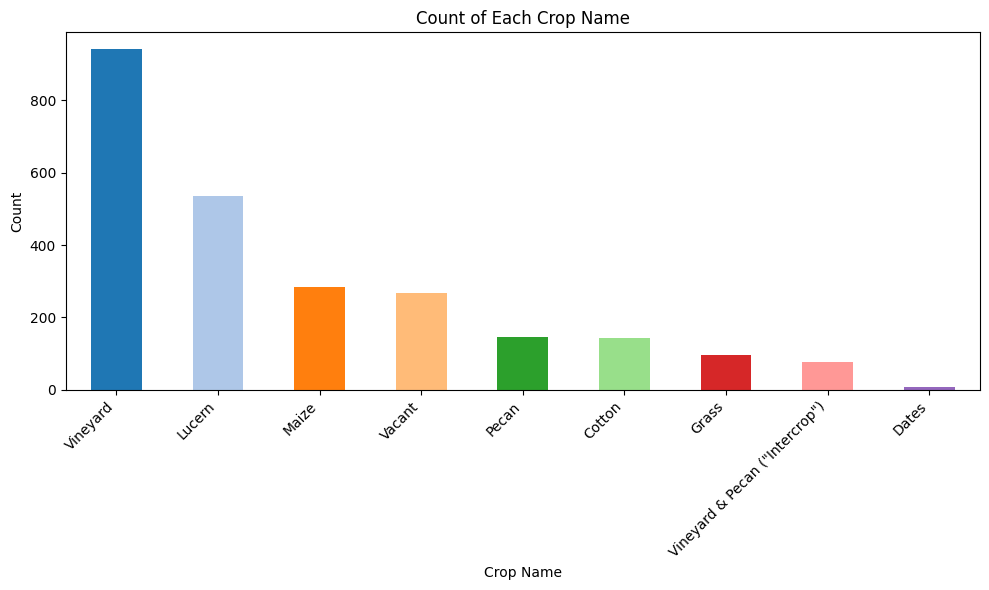

In [ ]:
crop_counts = df_full['crop_name'].value_counts()

plt.figure(figsize=(10, 6))
crop_counts.plot(kind='bar', color=[plt.cm.tab20(i) for i in range(len(crop_counts))])
plt.title('Count of Each Crop Name')
plt.xlabel('Crop Name')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [ ]:
np.unique(df_full['crop_name'])

array(['Cotton', 'Dates', 'Grass', 'Lucern', 'Maize', 'Pecan', 'Vacant',
       'Vineyard', 'Vineyard & Pecan ("Intercrop")'], dtype=object)

Then we create a box plot for each feature we have:

In [ ]:
df_full = df_full[~df_full['crop_name'].isin(['Vineyard & Pecan ("Intercrop")', 'Dates', 'Grass'])]

In [ ]:
df_full.reset_index(inplace=True, drop=True)

In [ ]:
selected_features = df_full.columns

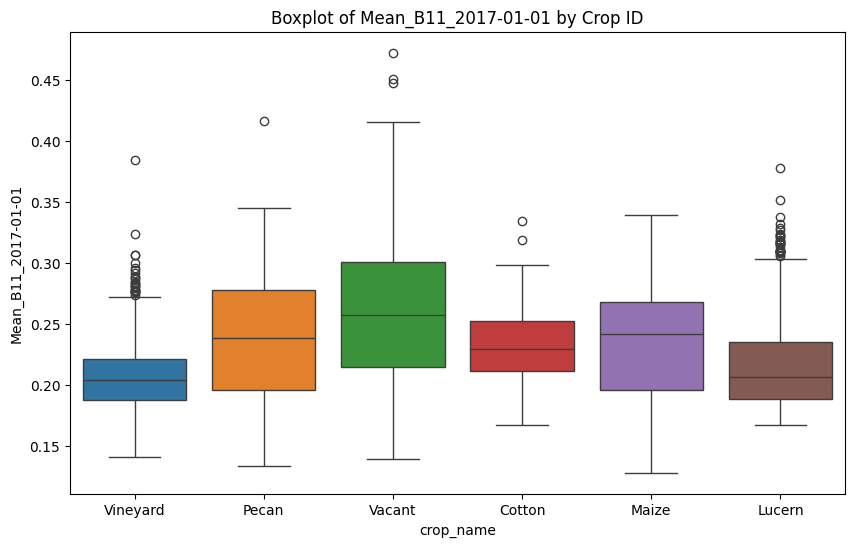

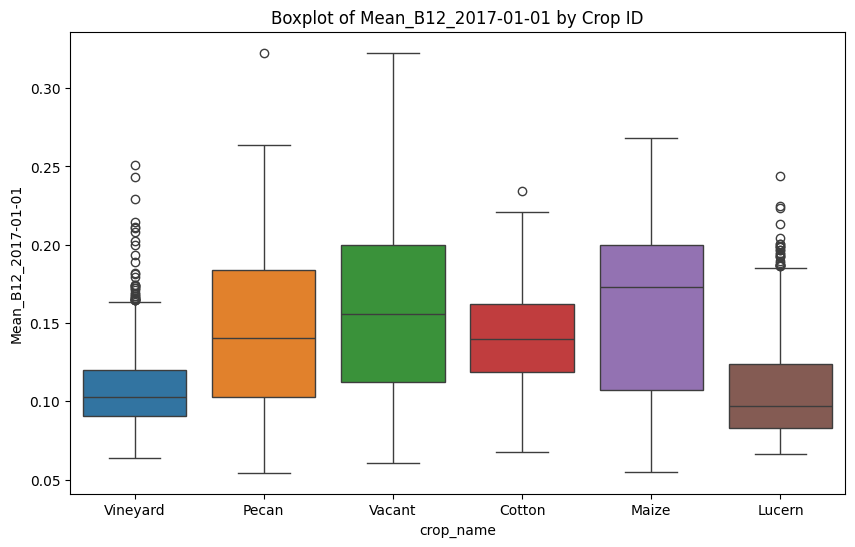

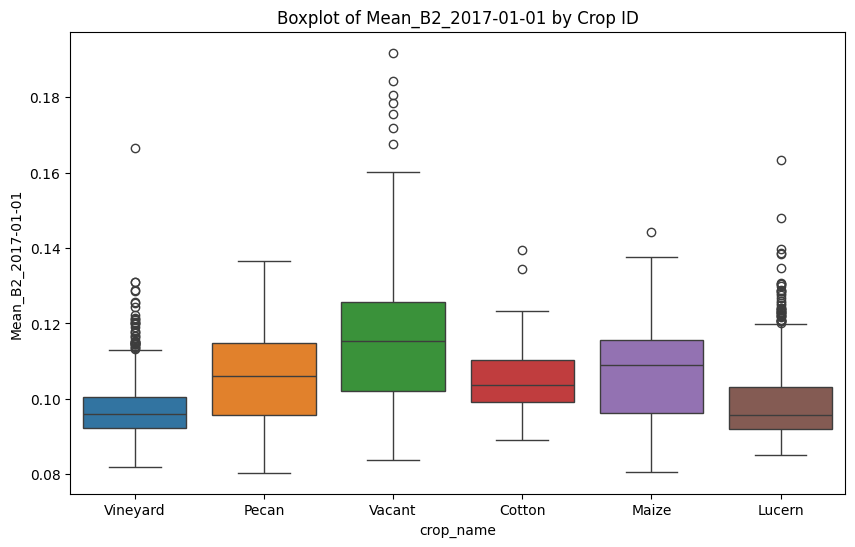

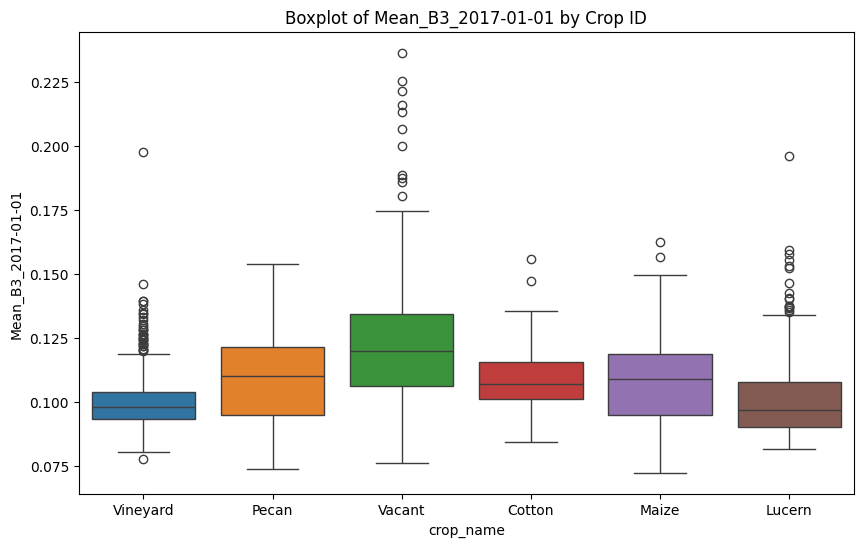

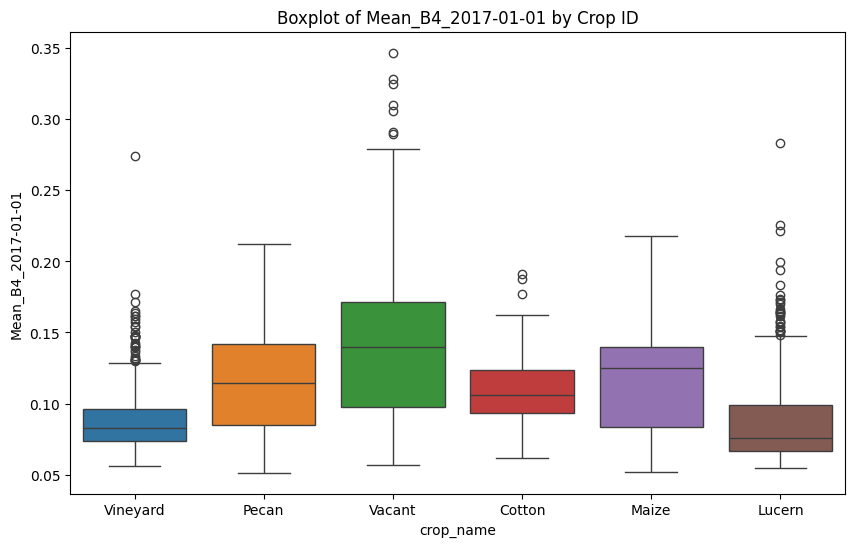

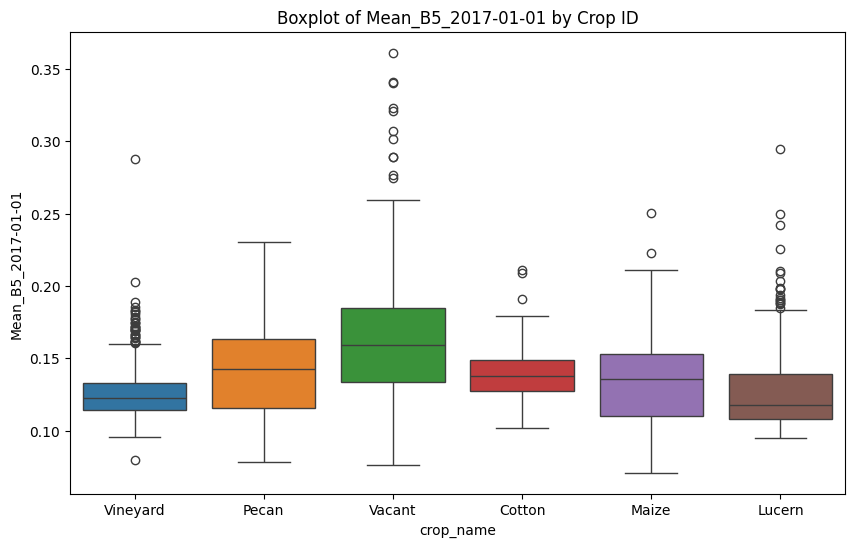

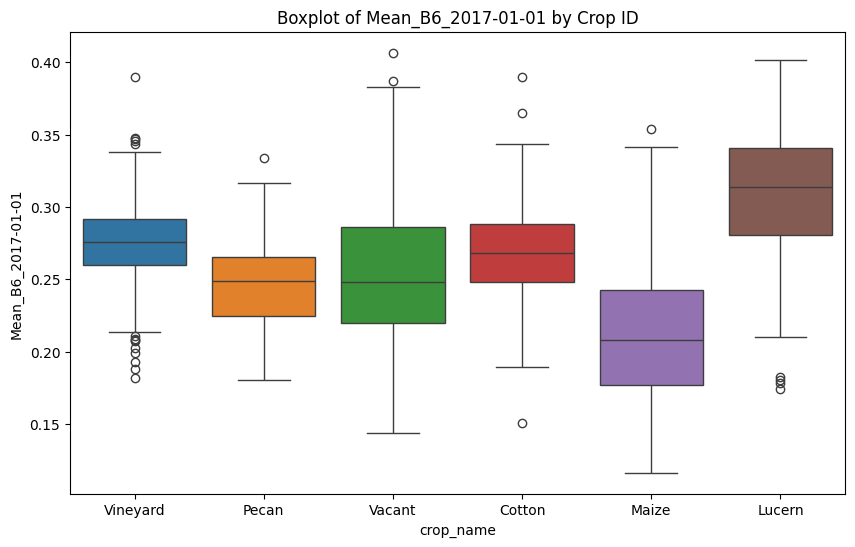

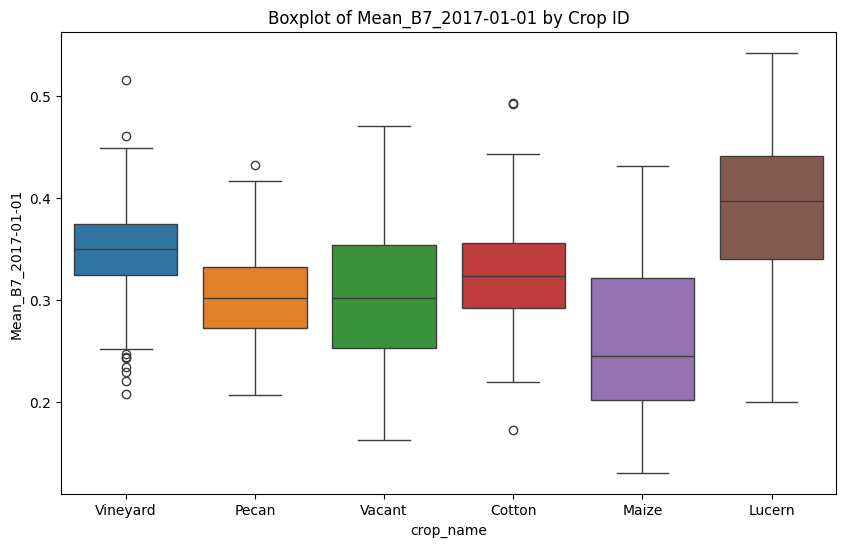

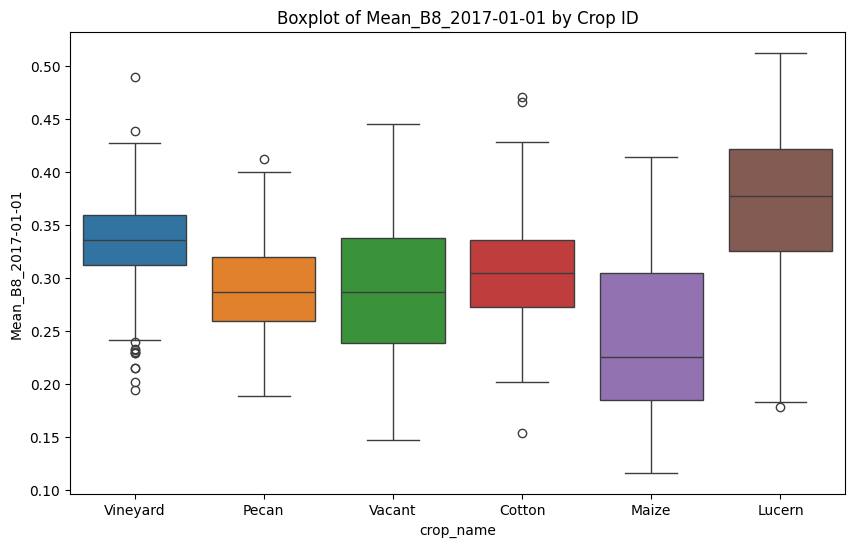

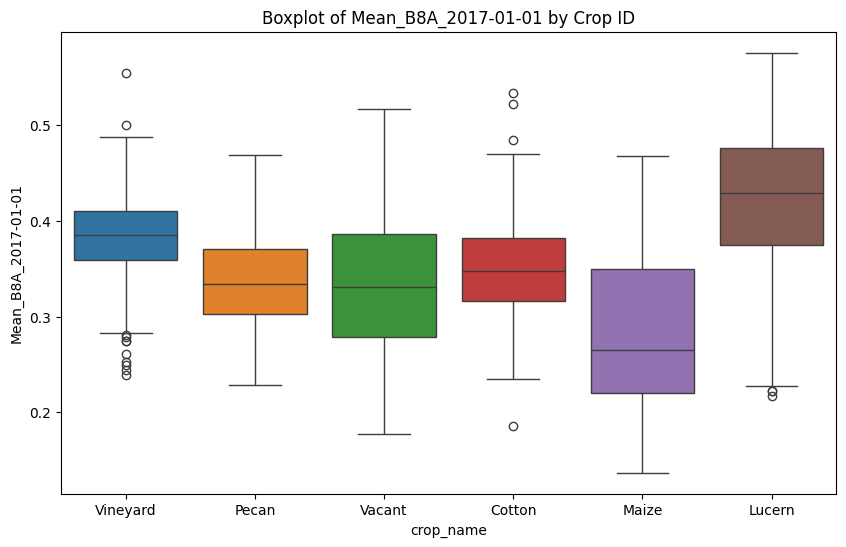

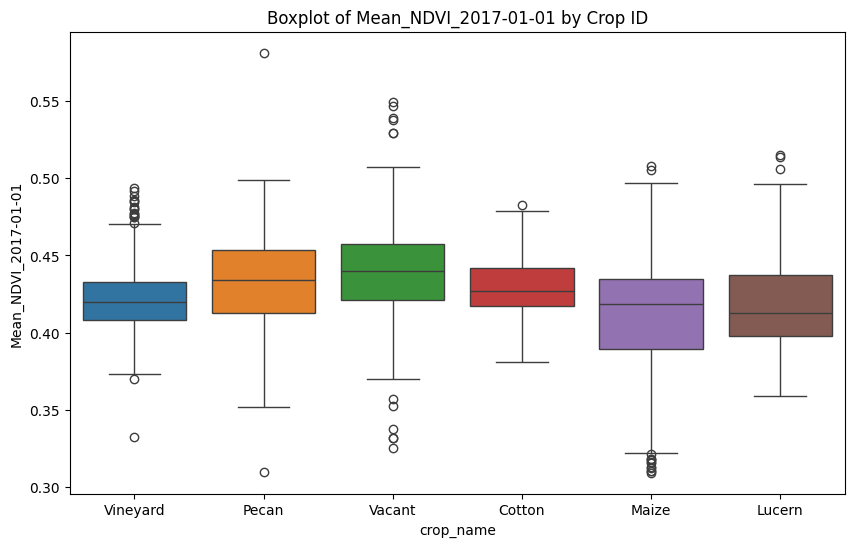

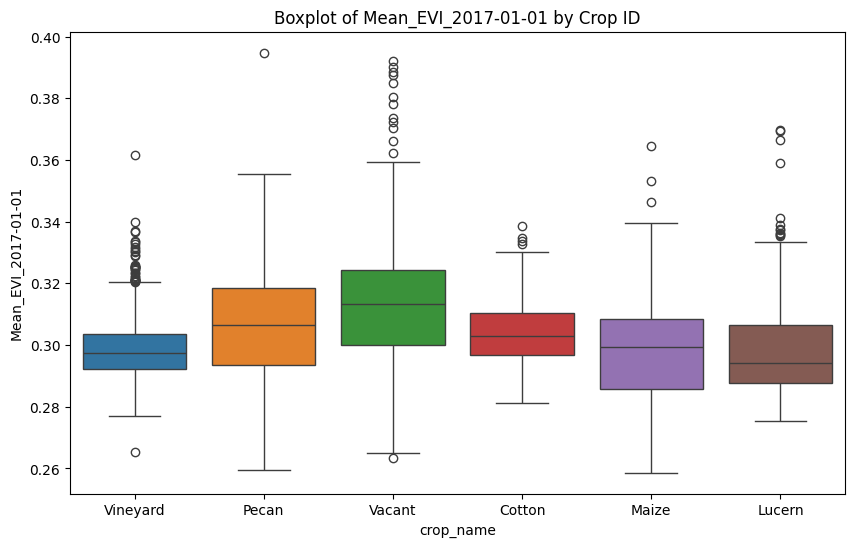

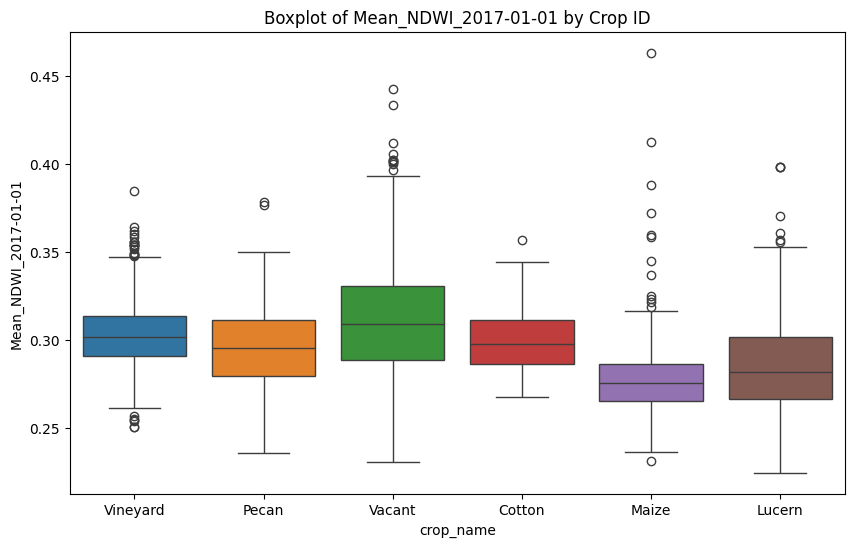

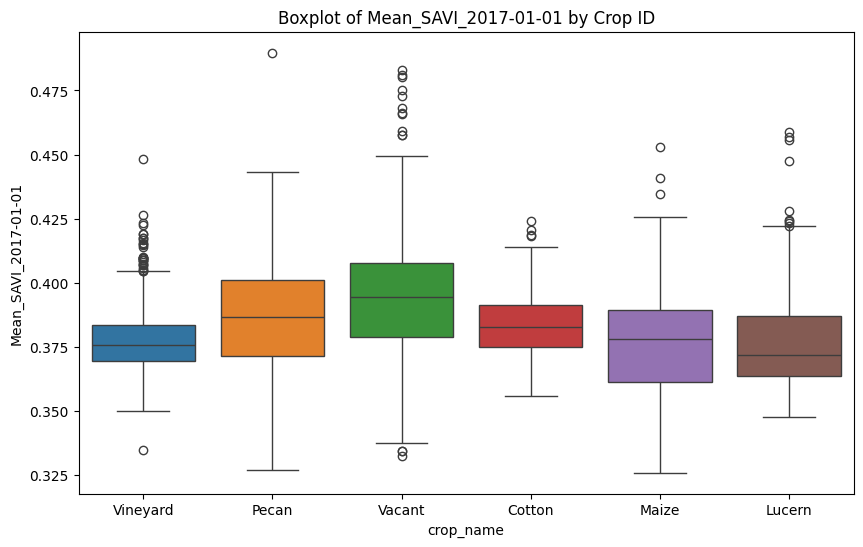

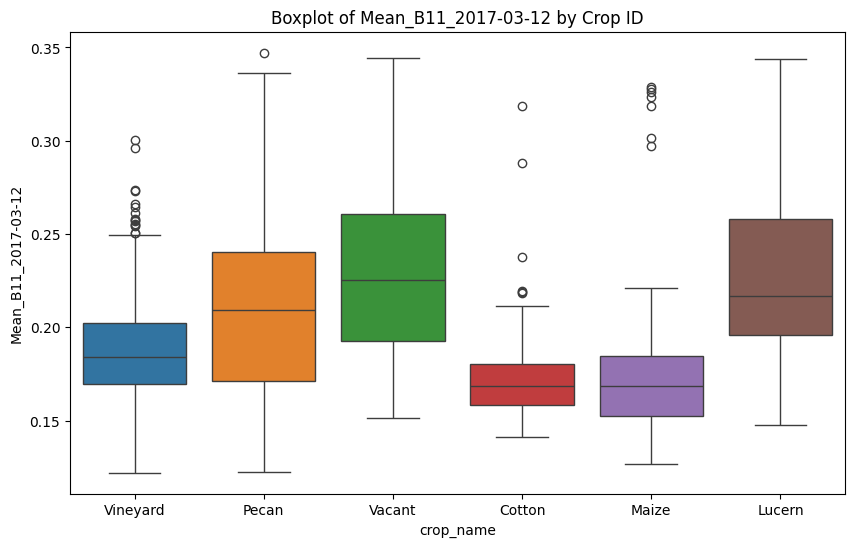

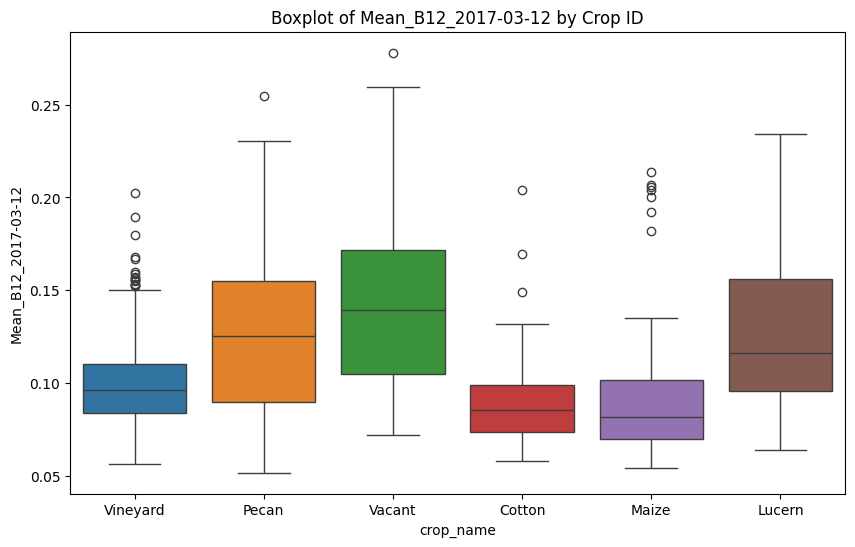

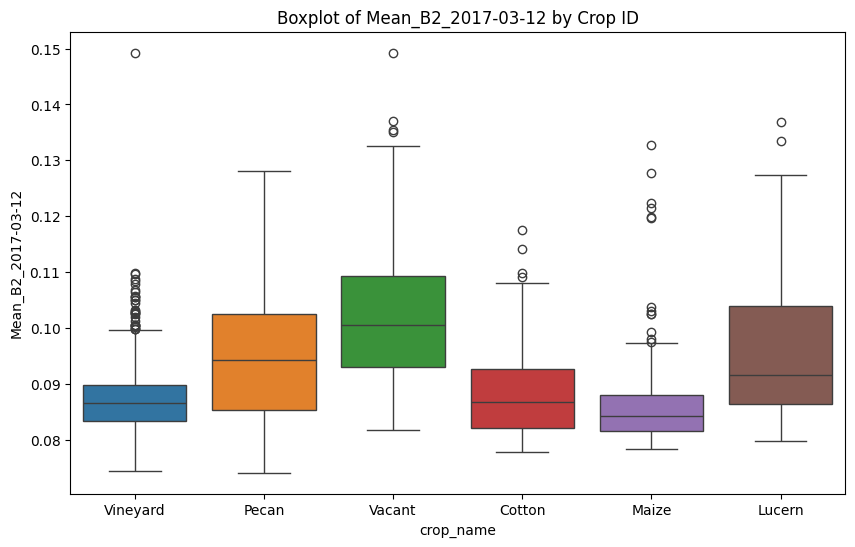

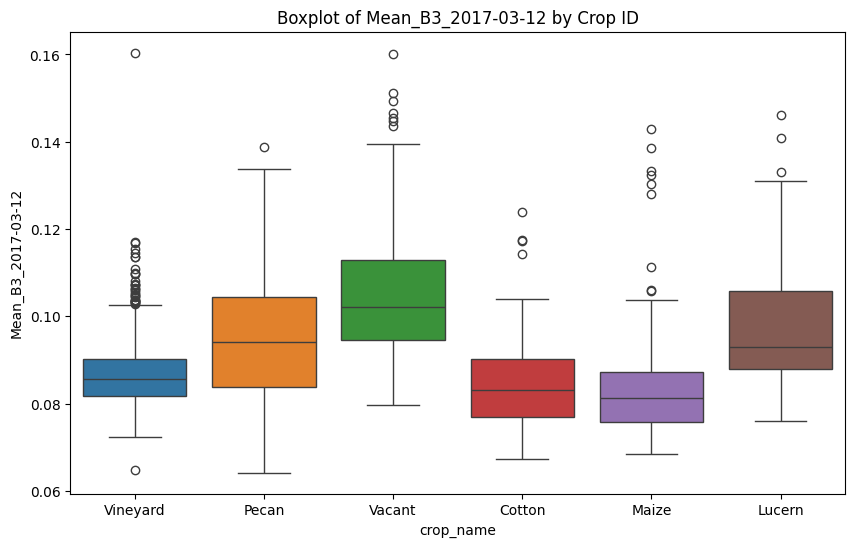

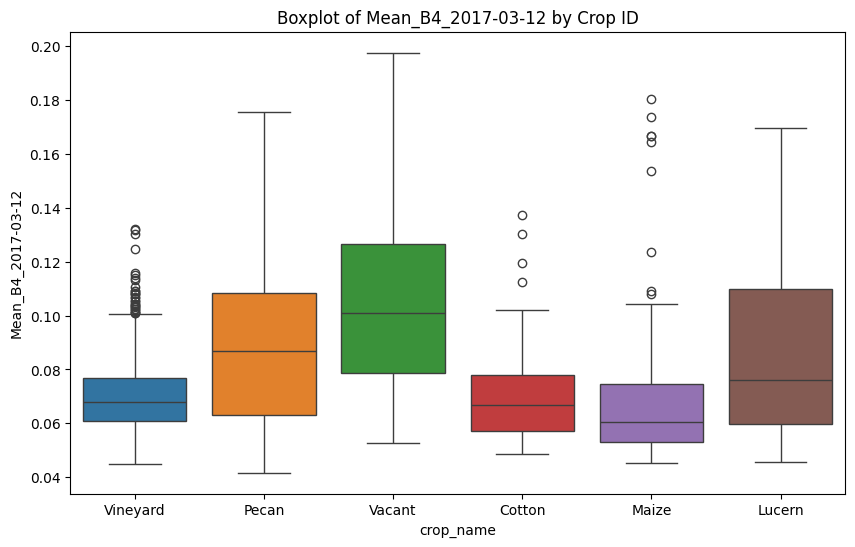

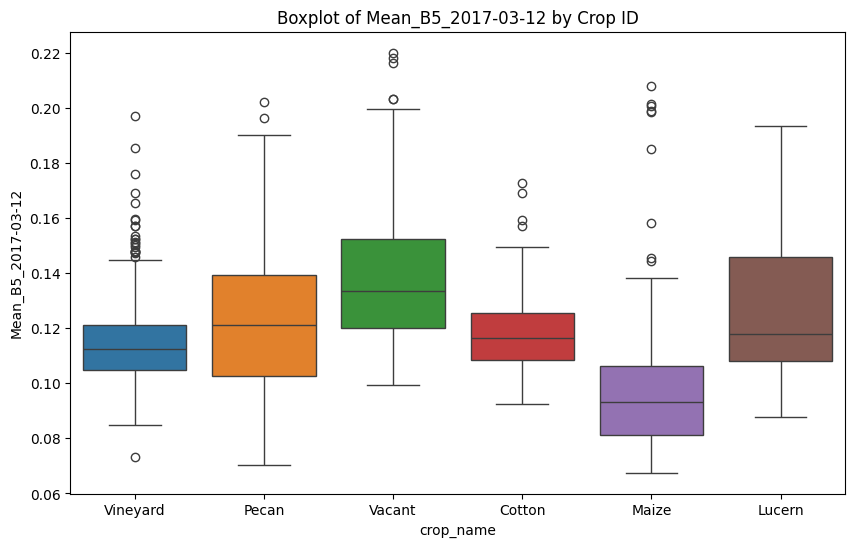

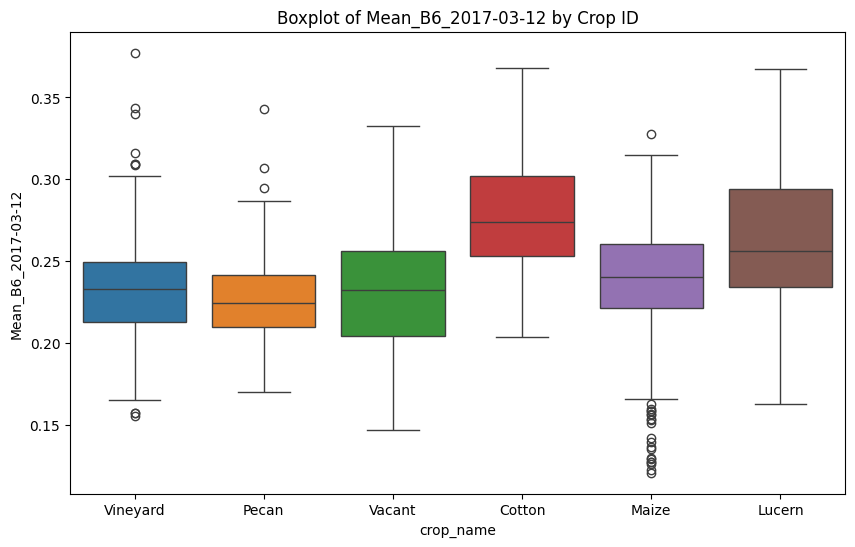

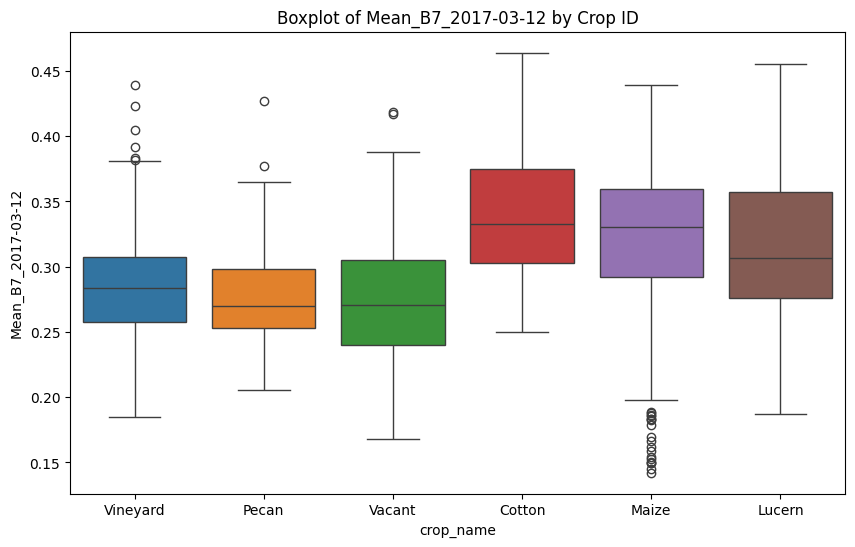

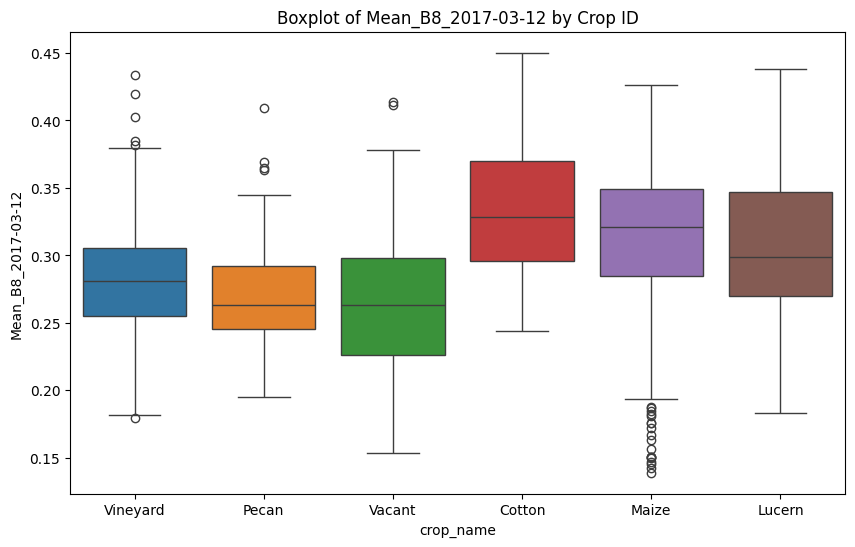

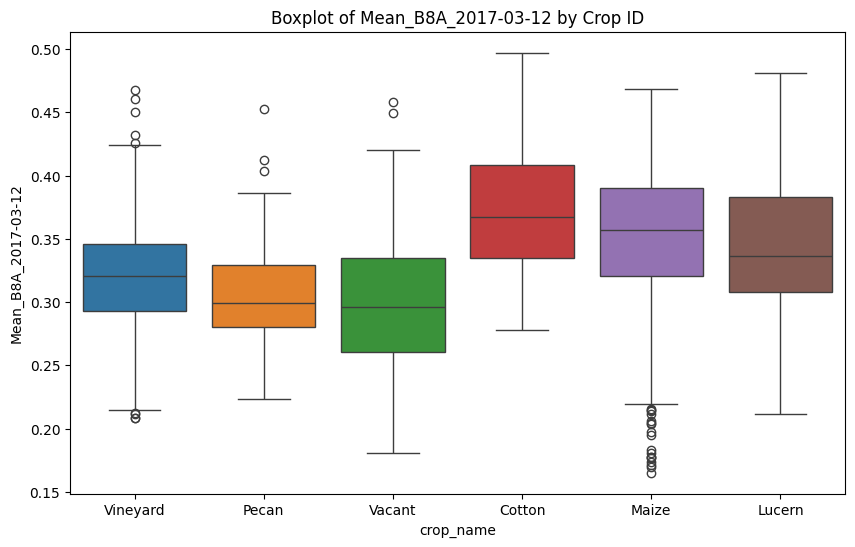

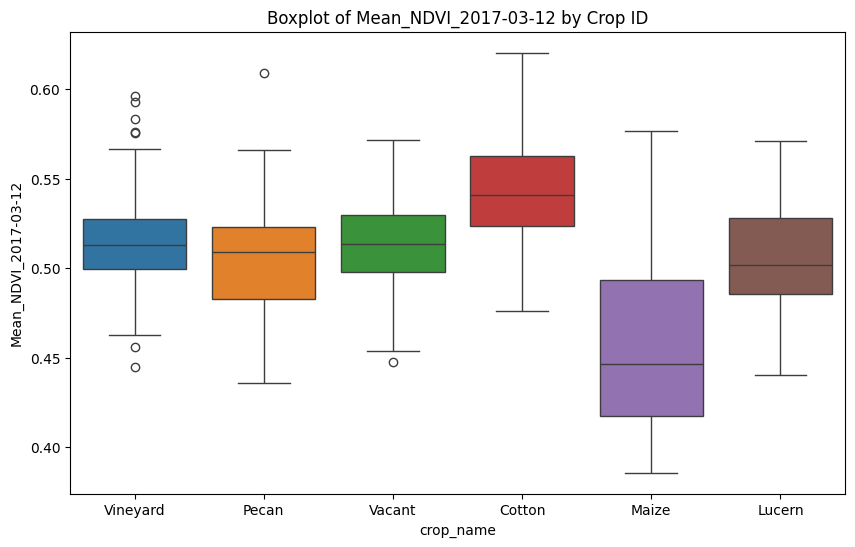

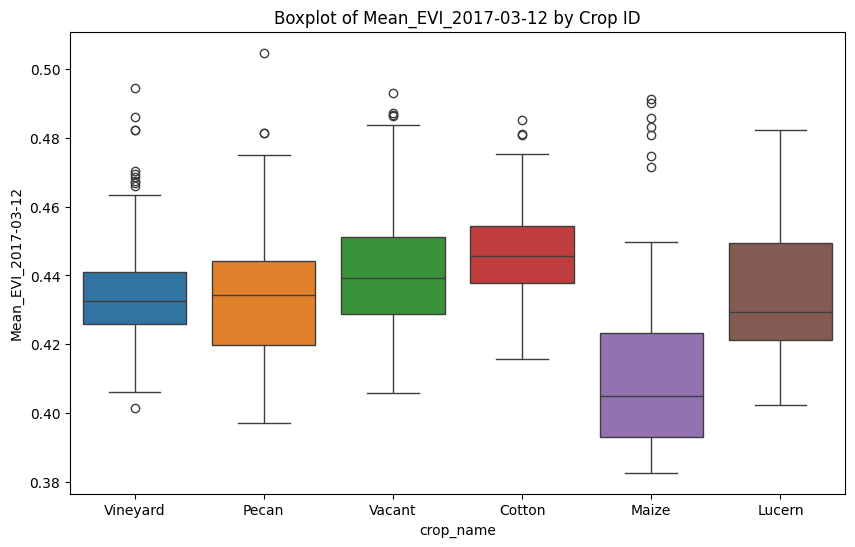

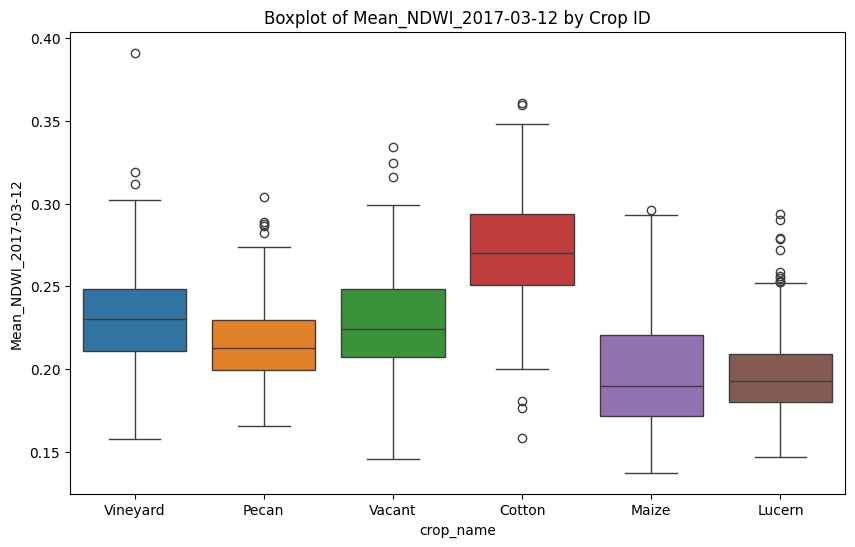

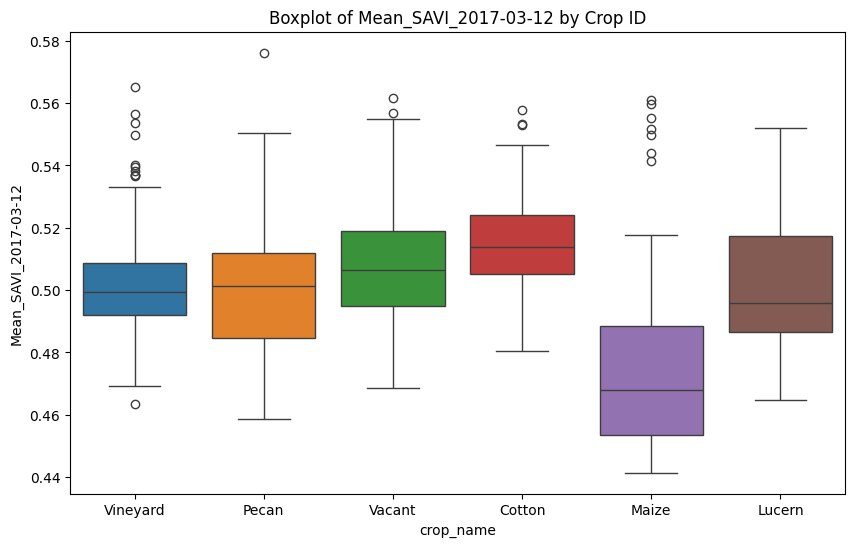

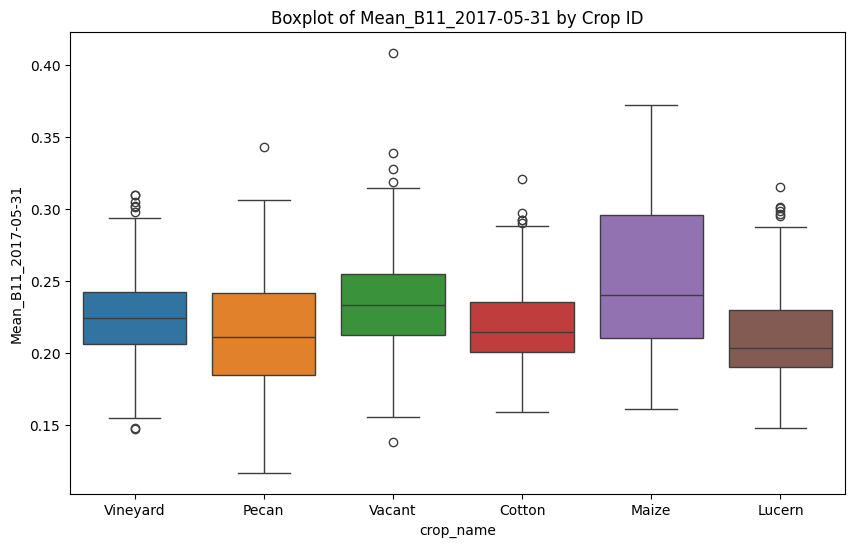

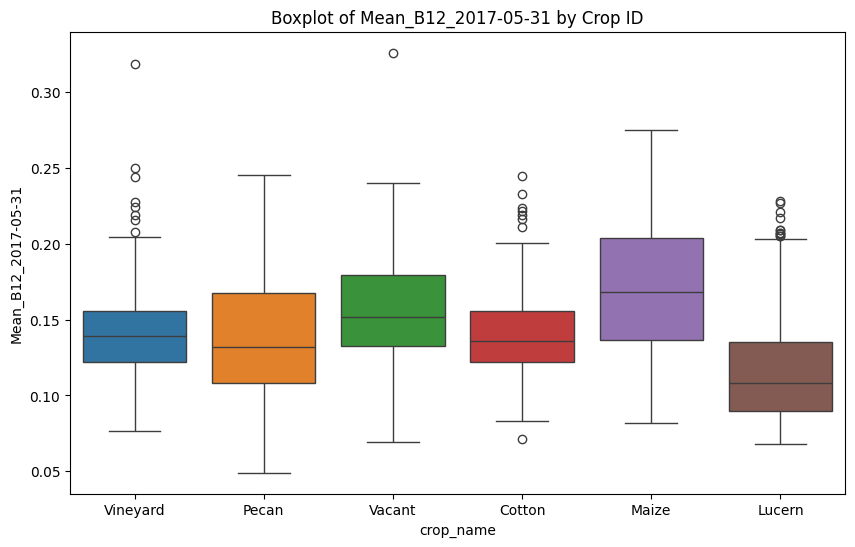

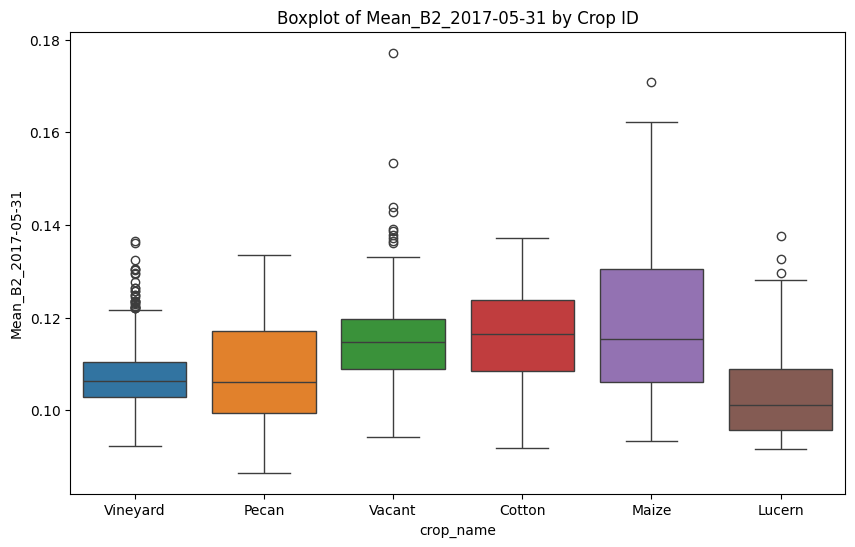

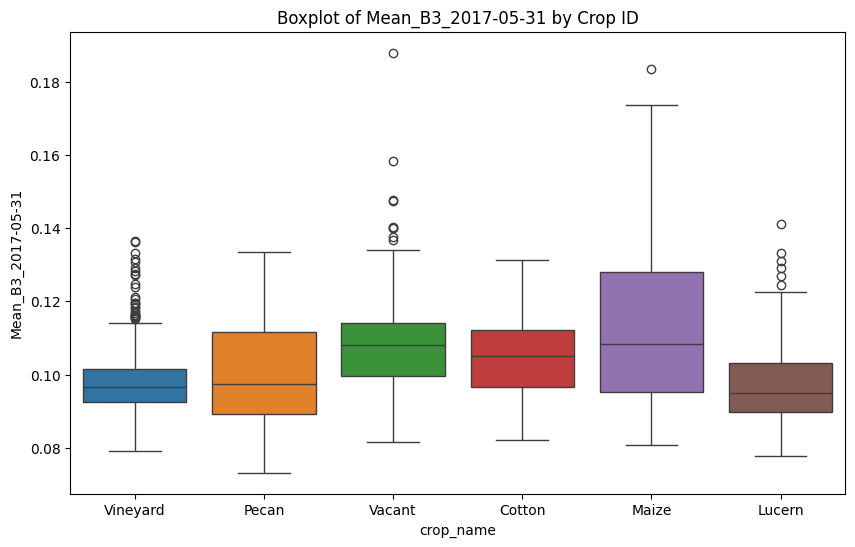

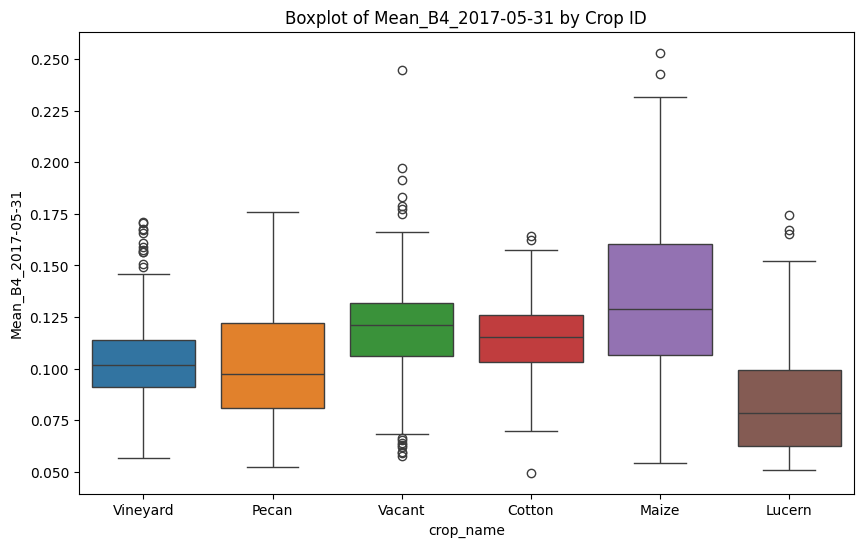

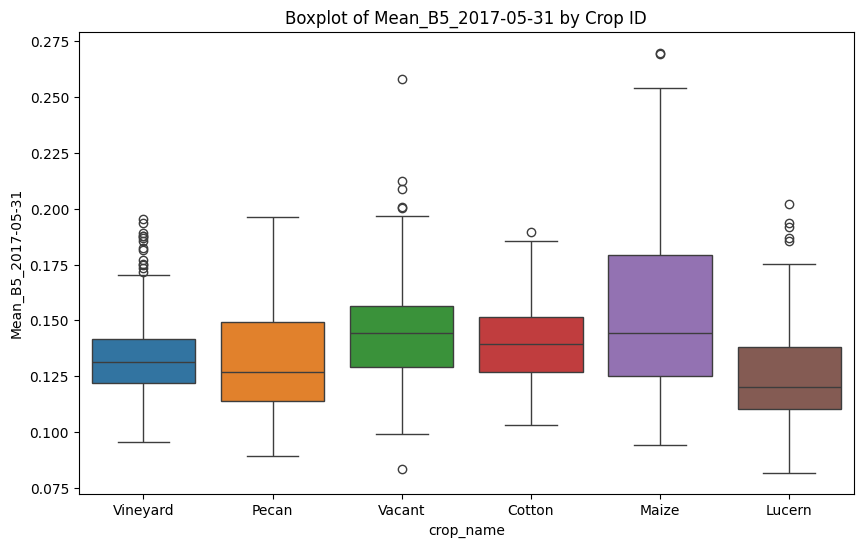

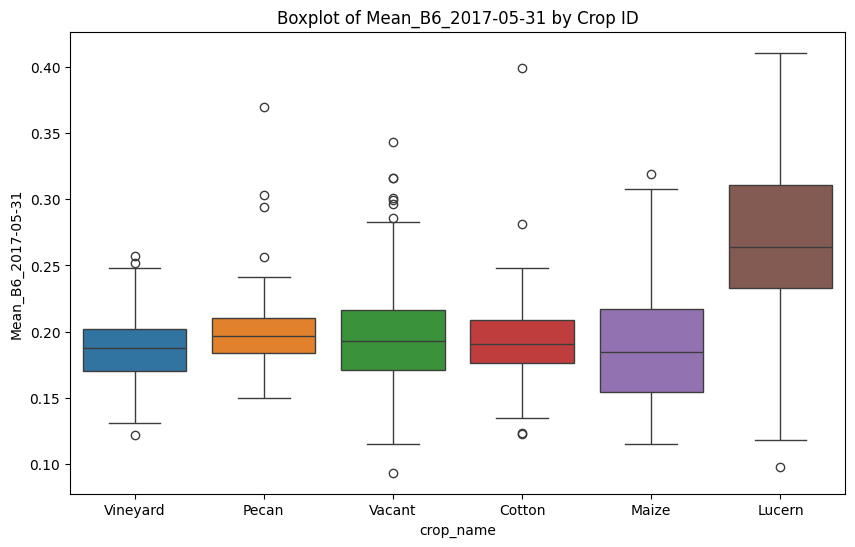

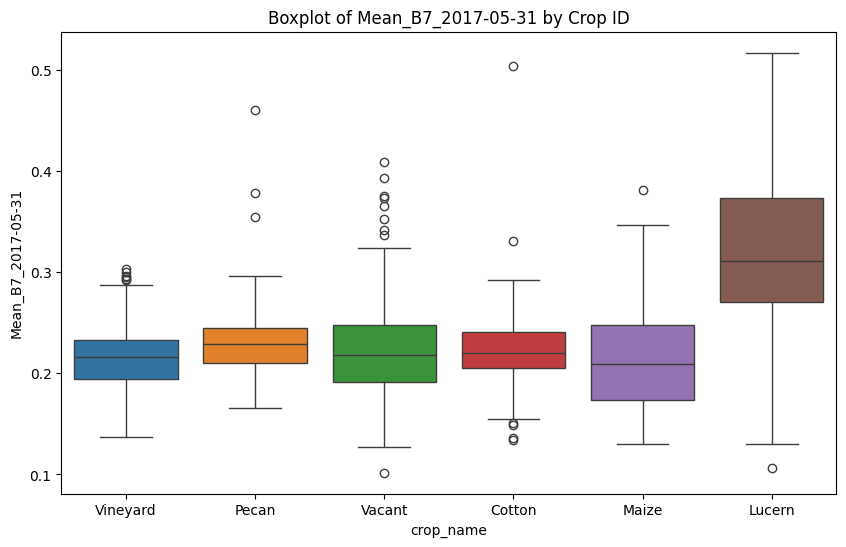

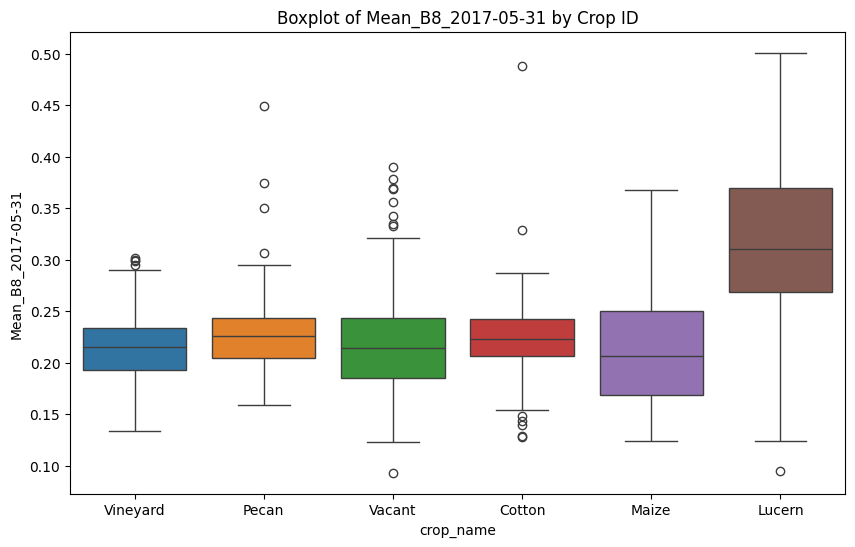

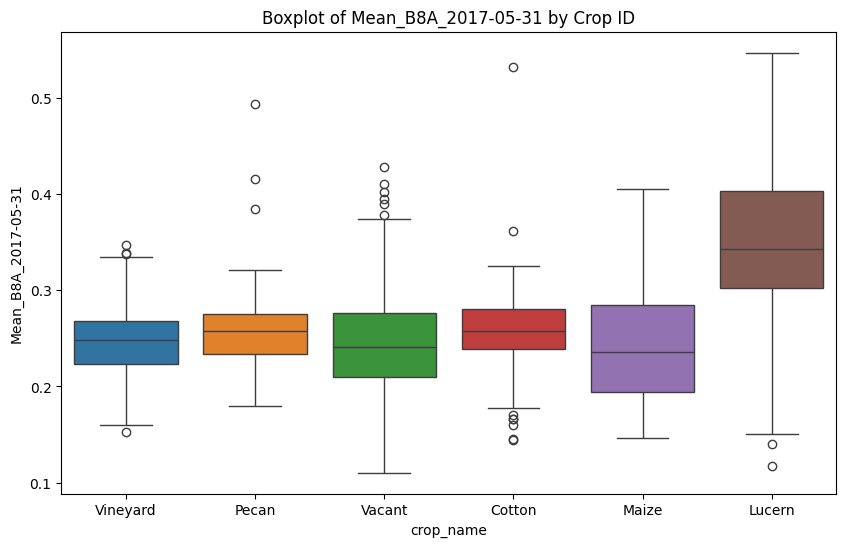

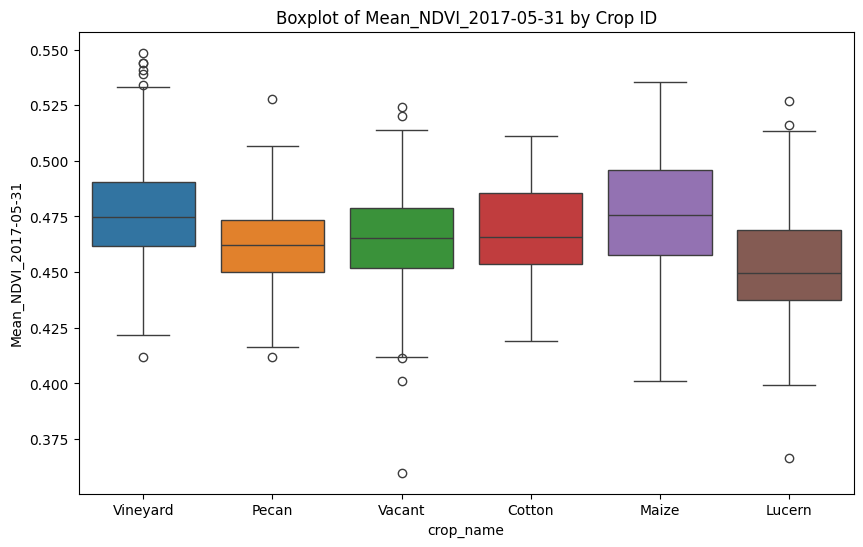

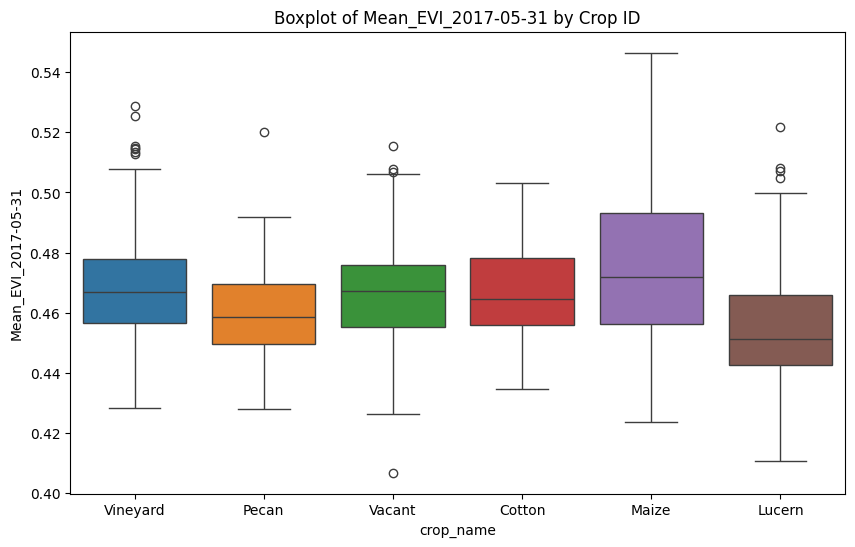

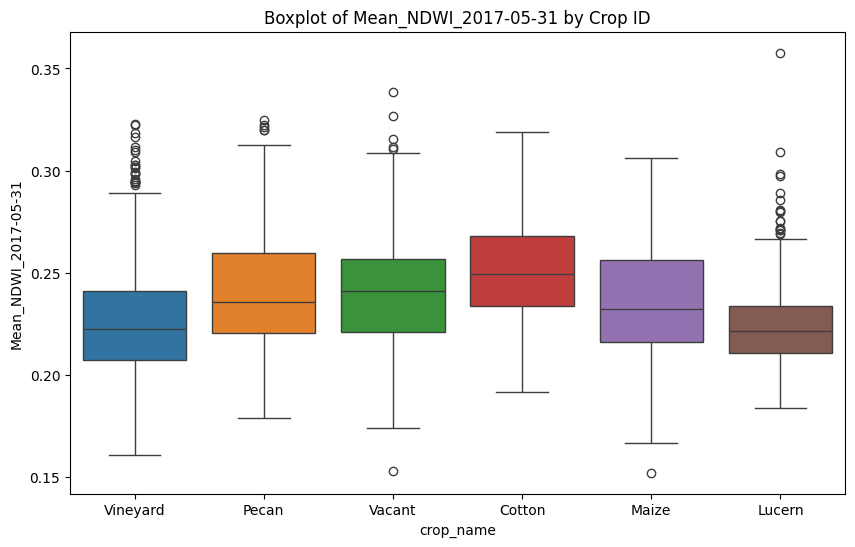

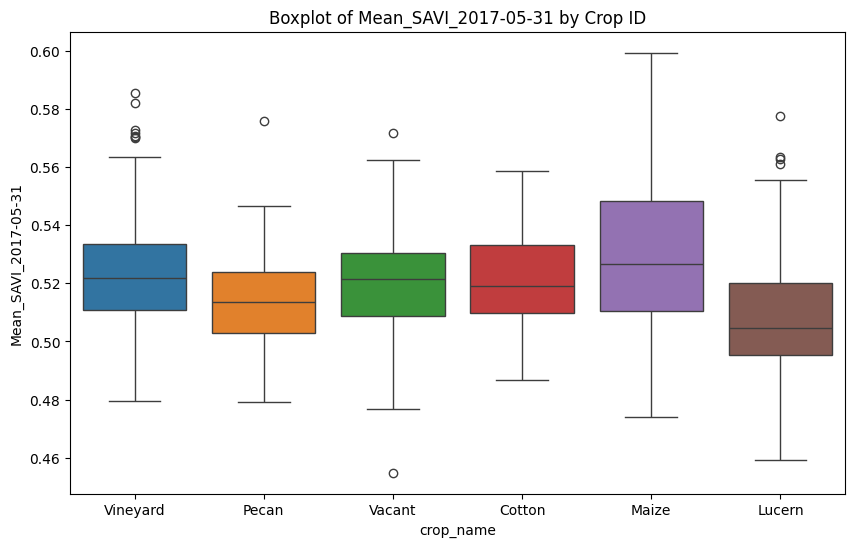

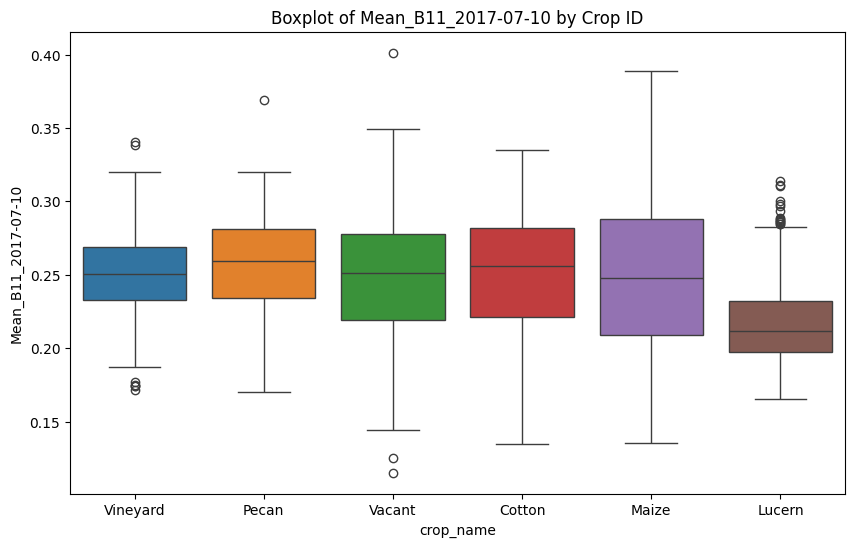

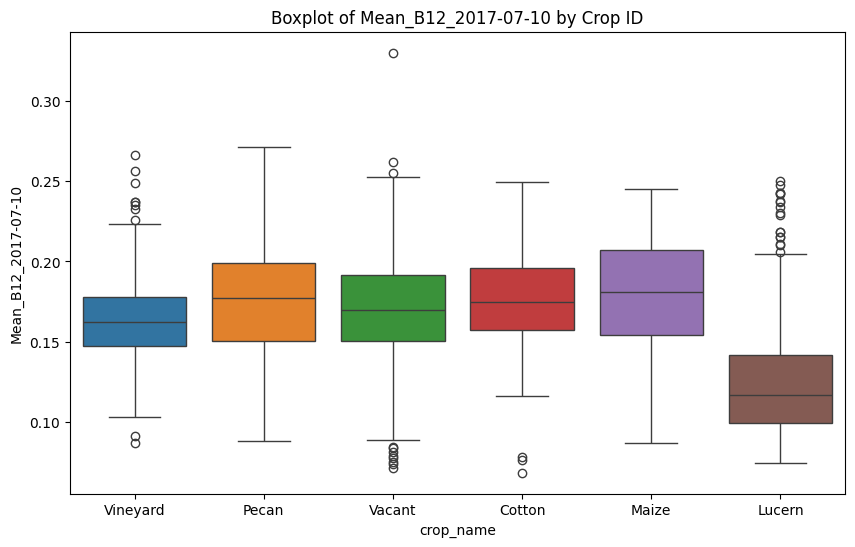

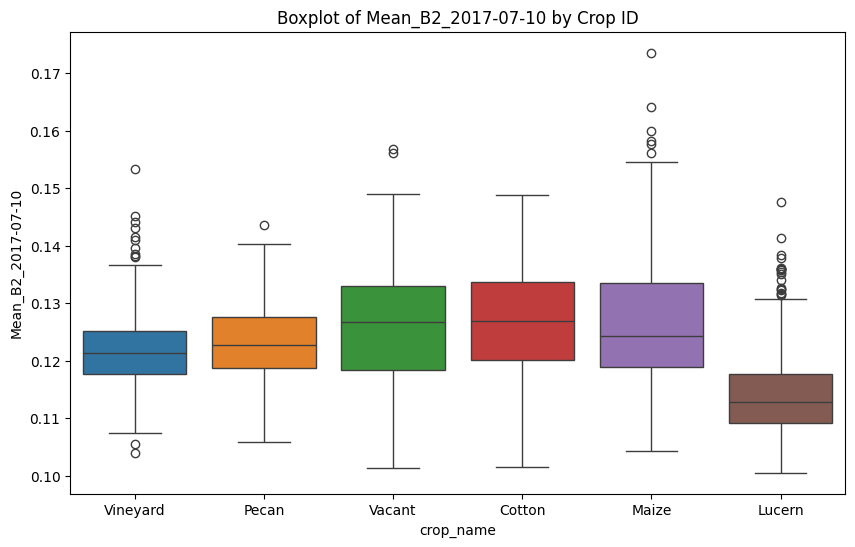

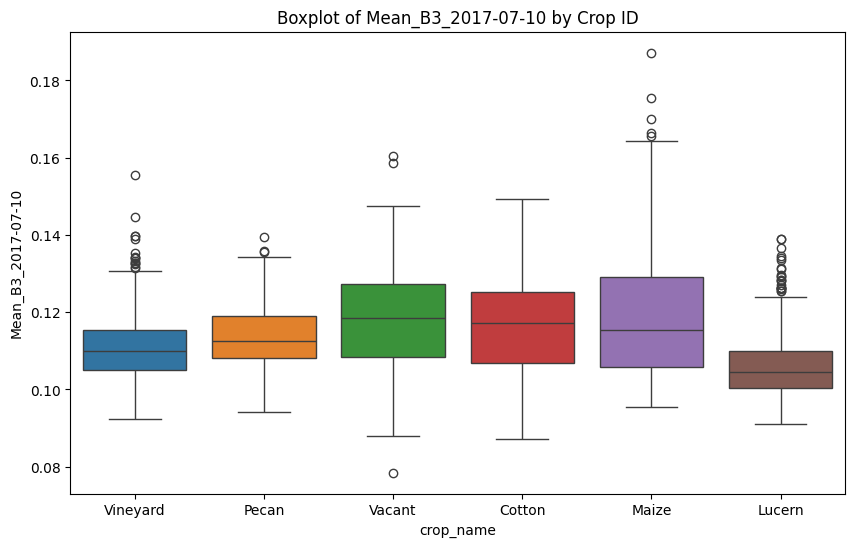

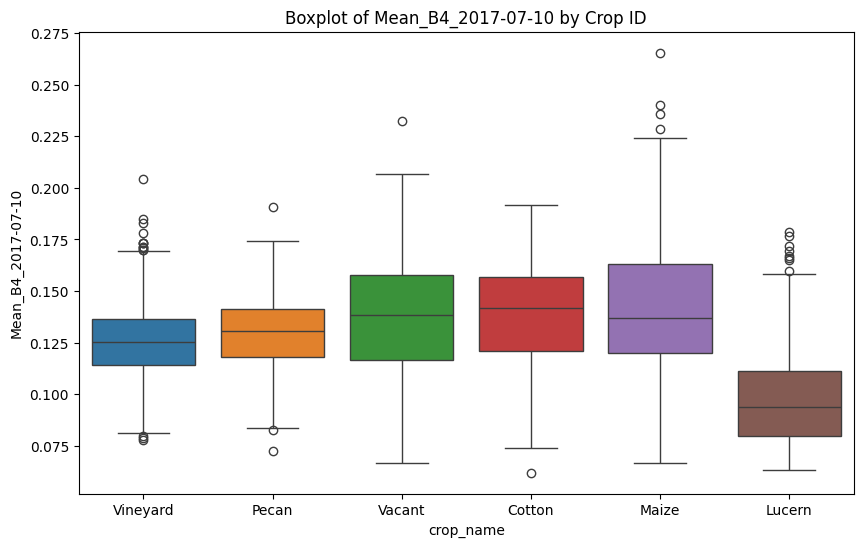

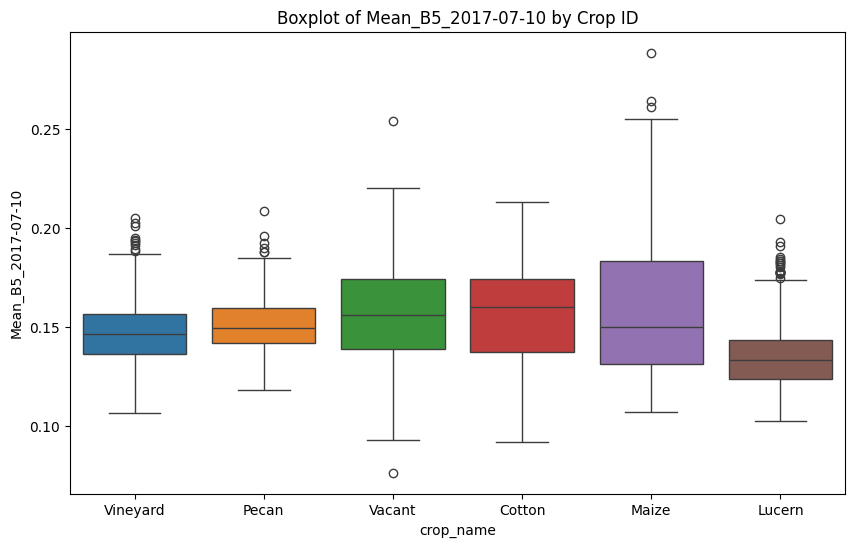

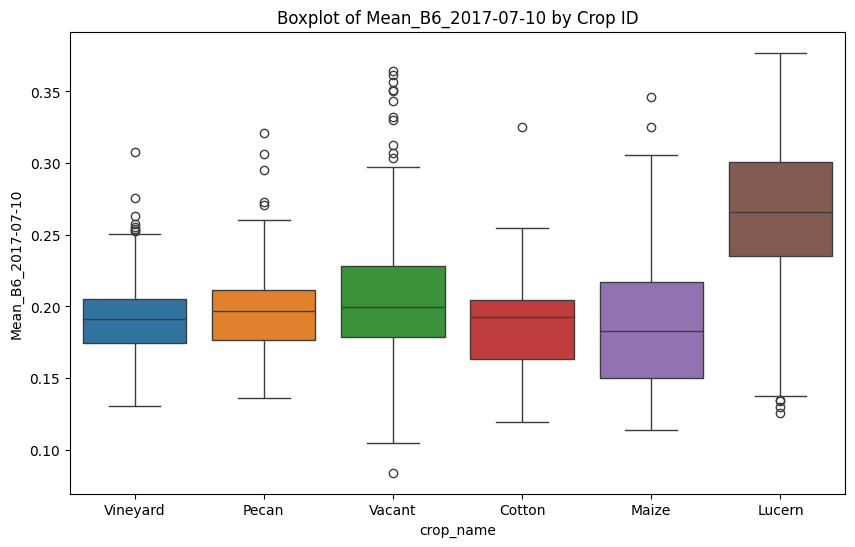

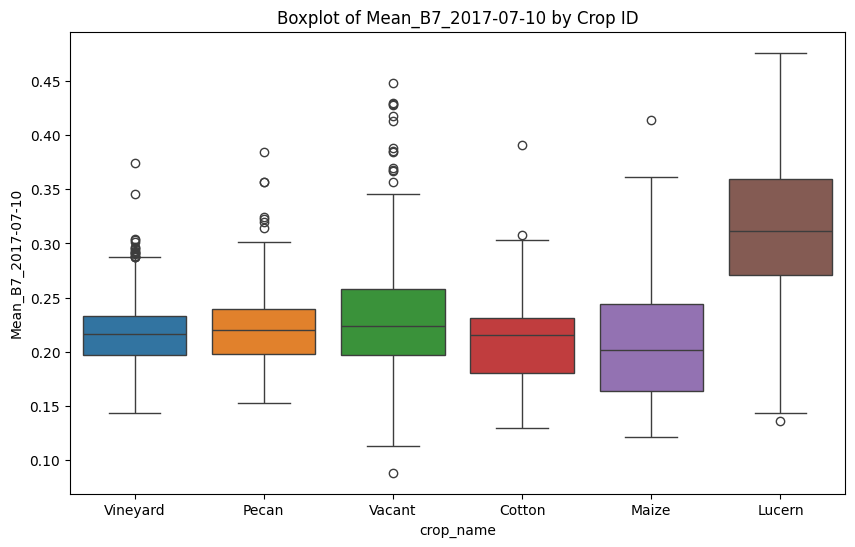

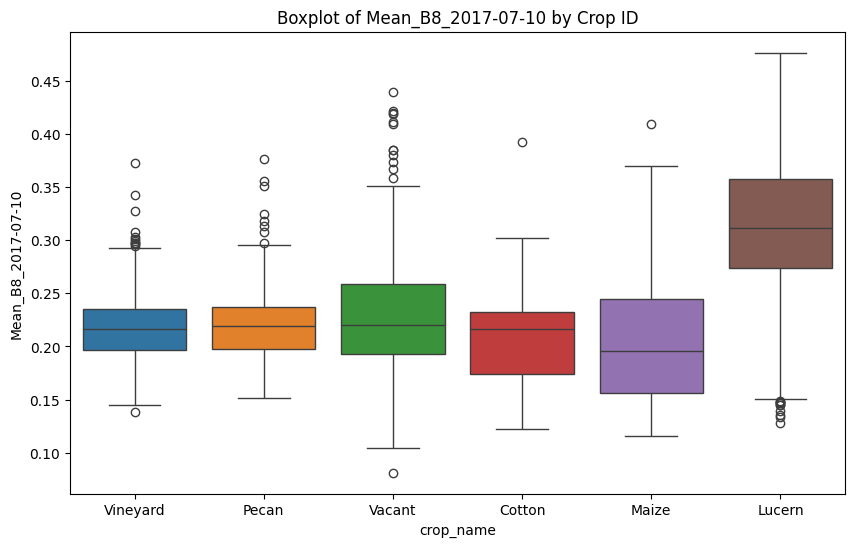

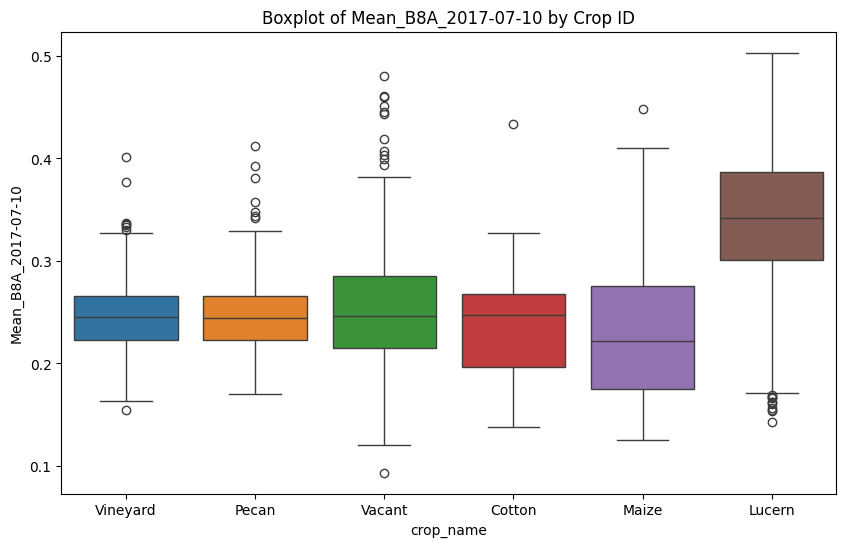

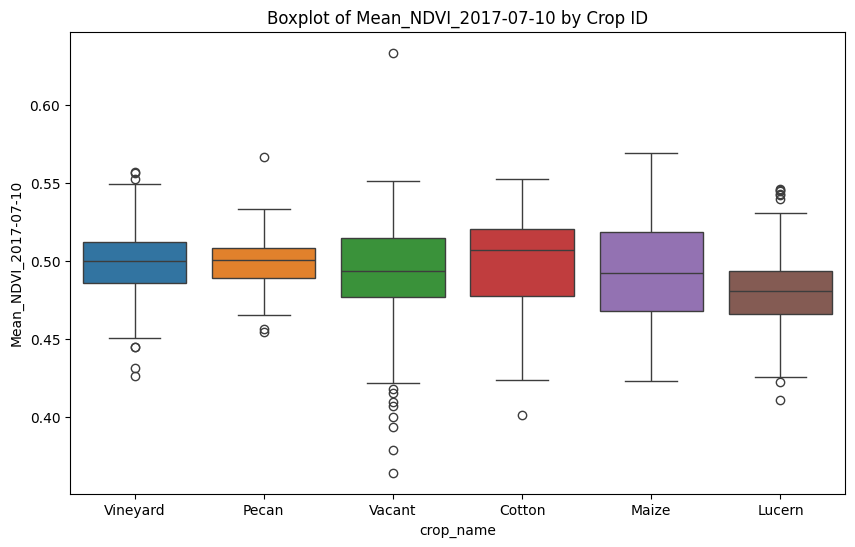

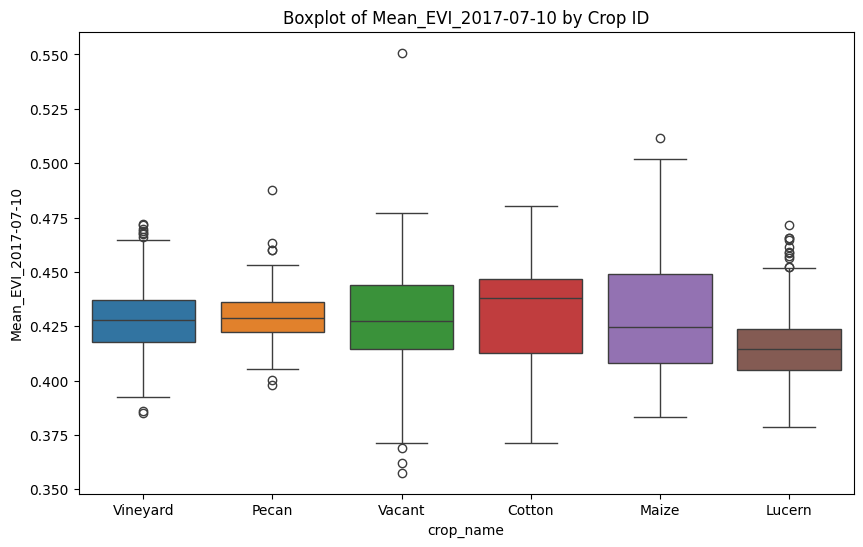

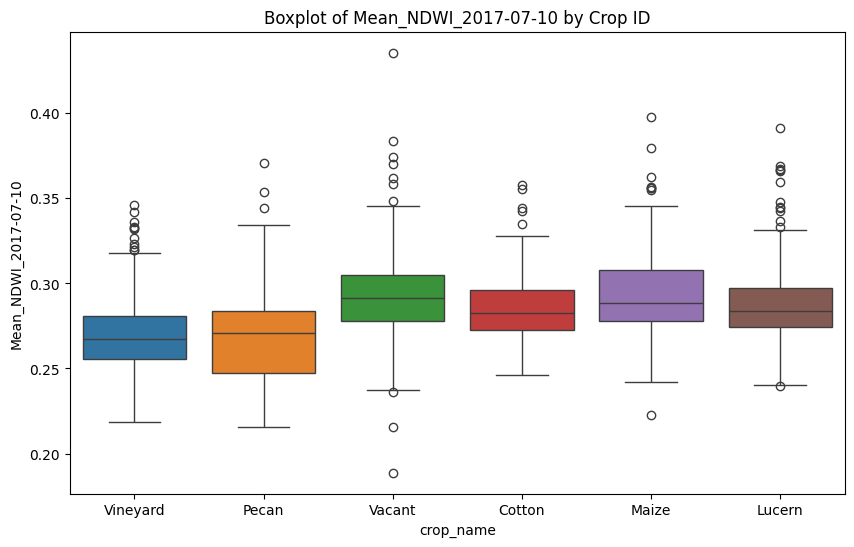

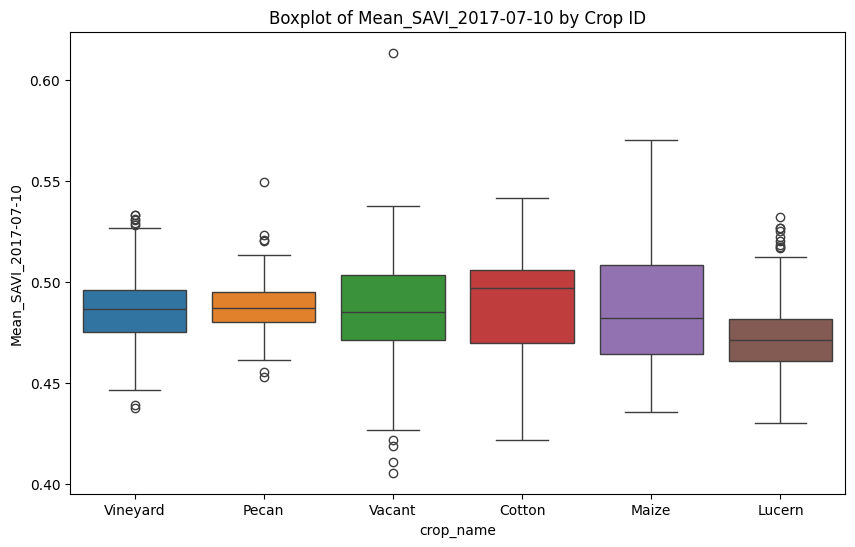

In [ ]:
# Box plots for selected features grouped by crop_id
for col in selected_features[:-2]:  # Exclude 'crop_id'
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='crop_name', y=col, data=df_full, hue='crop_name')
    plt.title(f'Boxplot of {col} by Crop ID')
    plt.show()

We will also create a correlation matrix:

In [ ]:
df_corr = df_full.drop(columns = ['crop_id', 'crop_name'])

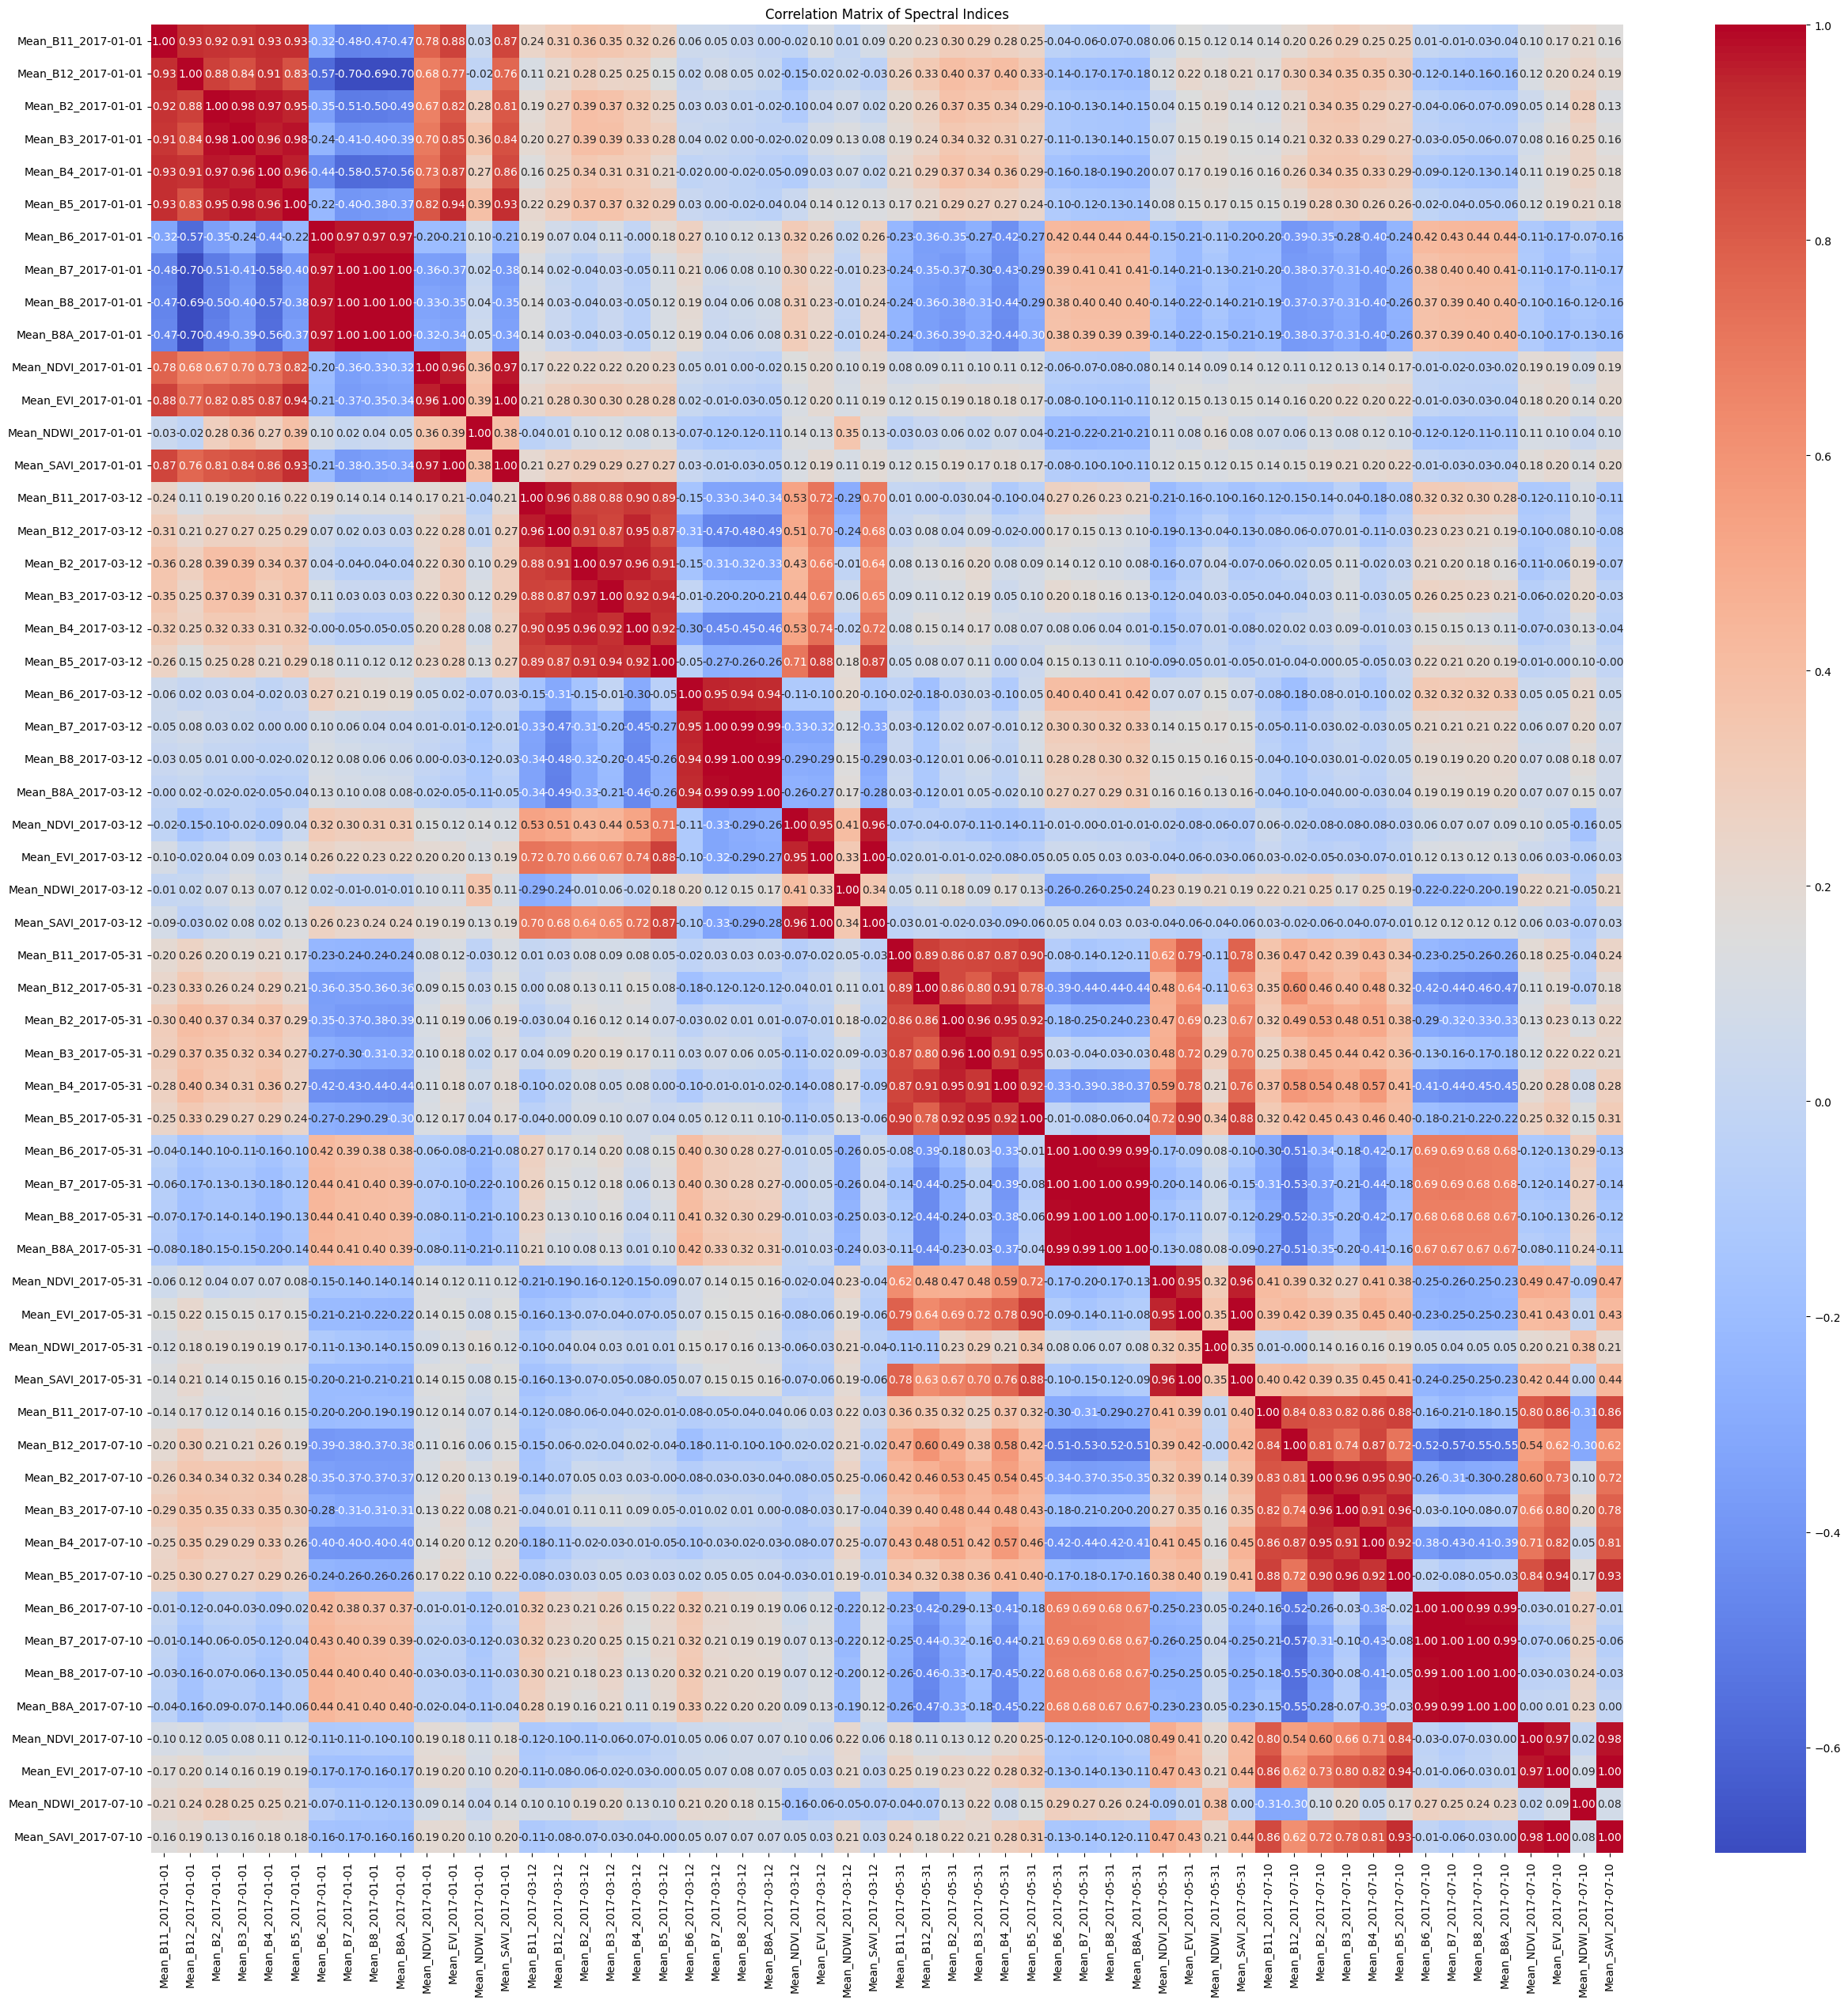

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(30, 30))
sns.heatmap(df_corr.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Spectral Indices')
plt.show()

In [ ]:
df_corr

Mean_B11_2017-01-01  Mean_B12_2017-01-01  Mean_B2_2017-01-01  \
0                0.206028             0.102933            0.088810   
1                0.191508             0.086720            0.089656   
2                0.197038             0.094090            0.098690   
3                0.171108             0.084691            0.084515   
4                0.193082             0.085912            0.087123   
...                   ...                  ...                 ...   
2310             0.169207             0.083444            0.091341   
2311             0.220701             0.134676            0.104632   
2312             0.153289             0.076449            0.091899   
2313             0.256336             0.183656            0.114092   
2314             0.212414             0.116880            0.099780   

      Mean_B3_2017-01-01  Mean_B4_2017-01-01  Mean_B5_2017-01-01  \
0               0.090833            0.073666            0.118106   
1               0.091737            0.071896            0.113876   
2               0.102548            0.098241            0.133849   
3               0.081665            0.062752            0.099187   
4               0.089032            0.067944            0.110683   
...                  ...                 ...                 ...   
2310            0.087157            0.068872            0.099409   
2311            0.104464            0.103488            0.127251   
2312            0.086822            0.070892            0.092908   
2313            0.114302            0.134835            0.146019   
2314            0.106266            0.099576            0.144992   

      Mean_B6_2017-01-01  Mean_B7_2017-01-01  Mean_B8_2017-01-01  \
0               0.287421            0.373812            0.372097   
1               0.310893            0.399079            0.380369   
2               0.261863            0.324137            0.315867   
3               0.251691            0.324614            0.318846   
4               0.298086            0.393583            0.378653   
...                  ...                 ...                 ...   
2310            0.252413            0.333017            0.318100   
2311            0.246232            0.312315            0.296908   
2312            0.227991            0.312187            0.293551   
2313            0.187581            0.216433            0.198164   
2314            0.277381            0.339146            0.330222   

      Mean_B8A_2017-01-01  ...  Mean_B4_2017-07-10  Mean_B5_2017-07-10  \
0                0.413409  ...            0.122219            0.143506   
1                0.438449  ...            0.082576            0.130071   
2                0.364675  ...            0.143123            0.168501   
3                0.356572  ...            0.116119            0.136751   
4                0.437584  ...            0.105604            0.147618   
...                   ...  ...                 ...                 ...   
2310             0.367947  ...            0.125390            0.138409   
2311             0.344412  ...            0.131836            0.147659   
2312             0.337309  ...            0.154240            0.167353   
2313             0.237154  ...            0.130259            0.142581   
2314             0.372939  ...            0.110764            0.153429   

      Mean_B6_2017-07-10  Mean_B7_2017-07-10  Mean_B8_2017-07-10  \
0               0.180257            0.204228            0.201454   
1               0.295327            0.356397            0.355920   
2               0.210014            0.236967            0.241846   
3               0.175184            0.200369            0.201673   
4               0.249137            0.293257            0.296747   
...                  ...                 ...                 ...   
2310            0.163698            0.182432            0.180587   
2311            0.180265            0.201263            0.198349   
2312            0.185377      

Let's apply PCA to get the uncorrelated features

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_corr)

In [ ]:
pca = PCA(n_components=0.95) # Example: keep components that explain 95% of the variance
pca_result = pca.fit_transform(scaled_data)

In [ ]:
pca_df = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])

In [ ]:
pca_df

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0     0.397210 -2.235266  0.434135  1.323918  0.722305  1.989933 -0.427478   
1    -6.766730  4.193342  1.253385  1.412016 -0.424938 -0.993729  0.012245   
2    -0.321829 -1.549380  1.640764 -1.036651 -3.403480 -0.529790 -1.236591   
3    -1.167163 -4.283615 -0.519466  0.414000  0.532081  0.533145 -0.164865   
4    -2.793582 -0.555916  3.758866  2.087616 -0.040589  1.562094  0.020530   
...        ...       ...       ...       ...       ...       ...       ...   
2310 -2.882395 -4.279015 -1.528395 -1.260426 -1.817529 -0.714550  1.018000   
2311 -0.743486 -0.491796 -2.853885 -1.441706 -2.216874 -2.051487  0.764522   
2312  1.622922  3.923781 -2.624347  7.171284  2.082424 -1.333390  5.948253   
2313  2.952924 -2.591952 -0.954710 -5.134035  0.122926 -0.896656  2.298494   
2314 -0.022222  4.250413  0.212073  2.097726 -1.318167  1.574786 -0.457122   

           PC8       PC9      PC10      PC11  
0     0.359070 -1.479985  0.077740 -1.491002  
1     1.206614 -1.054443 -0.123054 -0.120865  
2     2.707717  2.062256 -1.346961  0.007935  
3     1.071476 -1.439792  0.148469  0.198471  
4     2.662705 -1.592915  0.111886 -1.895897  
...        ...       ...       ...       ...  
2310  1.715716  1.179430 -2.009032 -0.690834  
2311 -0.424586  0.878058 -1.324388 -0.132635  
2312 -0.071498  0.751183 -0.389068 -1.447597  
2313 -1.307667  0.604687  0.583956 -0.011153  
2314  2.703155 -0.139172  1.047976  0.334807  

[2315 rows x 11 columns]

In [ ]:
pca_df['crop_id'] = df_full['crop_id']
pca_df['crop_name'] = df_full['crop_name']

In [ ]:
pca_df

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0     0.397210 -2.235266  0.434135  1.323918  0.722305  1.989933 -0.427478   
1    -6.766730  4.193342  1.253385  1.412016 -0.424938 -0.993729  0.012245   
2    -0.321829 -1.549380  1.640764 -1.036651 -3.403480 -0.529790 -1.236591   
3    -1.167163 -4.283615 -0.519466  0.414000  0.532081  0.533145 -0.164865   
4    -2.793582 -0.555916  3.758866  2.087616 -0.040589  1.562094  0.020530   
...        ...       ...       ...       ...       ...       ...       ...   
2310 -2.882395 -4.279015 -1.528395 -1.260426 -1.817529 -0.714550  1.018000   
2311 -0.743486 -0.491796 -2.853885 -1.441706 -2.216874 -2.051487  0.764522   
2312  1.622922  3.923781 -2.624347  7.171284  2.082424 -1.333390  5.948253   
2313  2.952924 -2.591952 -0.954710 -5.134035  0.122926 -0.896656  2.298494   
2314 -0.022222  4.250413  0.212073  2.097726 -1.318167  1.574786 -0.457122   

           PC8       PC9      PC10      PC11  crop_id crop_name  
0     0.359070 -1.479985  0.077740 -1.491002        8  Vineyard  
1     1.206614 -1.054443 -0.123054 -0.120865        6     Pecan  
2     2.707717  2.062256 -1.346961  0.007935        8  Vineyard  
3     1.071476 -1.439792  0.148469  0.198471        8  Vineyard  
4     2.662705 -1.592915  0.111886 -1.895897        8  Vineyard  
...        ...       ...       ...       ...      ...       ...  
2310  1.715716  1.179430 -2.009032 -0.690834        6     Pecan  
2311 -0.424586  0.878058 -1.324388 -0.132635        6     Pecan  
2312 -0.071498  0.751183 -0.389068 -1.447597        6     Pecan  
2313 -1.307667  0.604687  0.583956 -0.011153        6     Pecan  
2314  2.703155 -0.139172  1.047976  0.334807        6     Pecan  

[2315 rows x 13 columns]

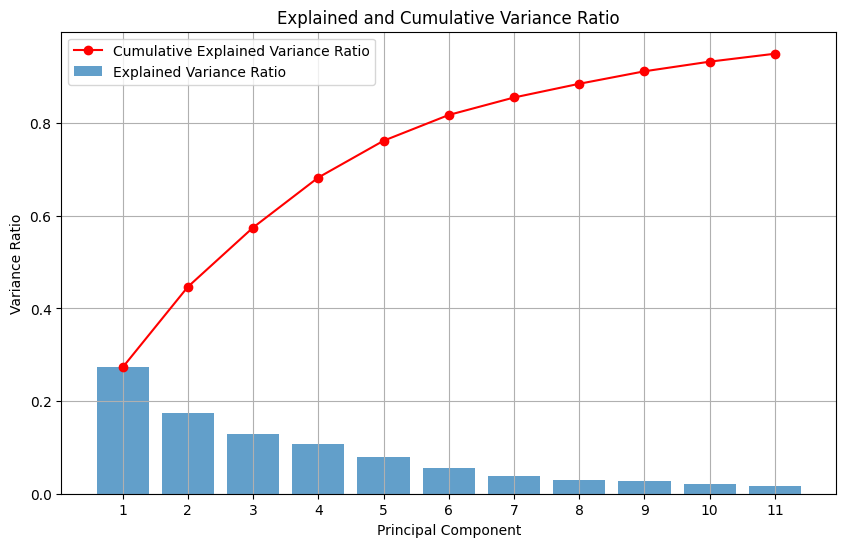

In [ ]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)


plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, align='center', label='Explained Variance Ratio')
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='-', color='red', label='Cumulative Explained Variance Ratio')

plt.xlabel('Principal Component')
plt.ylabel('Variance Ratio')
plt.title('Explained and Cumulative Variance Ratio')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.legend()
plt.grid(True)
plt.show()

Then we will apply the random forest for classification:

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
X = pca_df.drop(['crop_id', 'crop_name'], axis=1)
y = pca_df['crop_name']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=500, random_state=42) # You can adjust hyperparameters
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, random_state=42)

We can check the metrics:

In [ ]:
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Accuracy: 0.8272138228941684
              precision    recall  f1-score   support

      Cotton       0.79      0.76      0.78        25
      Lucern       0.88      0.85      0.86       118
       Maize       0.87      0.84      0.86        57
       Pecan       0.71      0.22      0.33        23
      Vacant       0.50      0.55      0.53        38
    Vineyard       0.86      0.94      0.90       202

    accuracy                           0.83       463
   macro avg       0.77      0.69      0.71       463
weighted avg       0.83      0.83      0.82       463



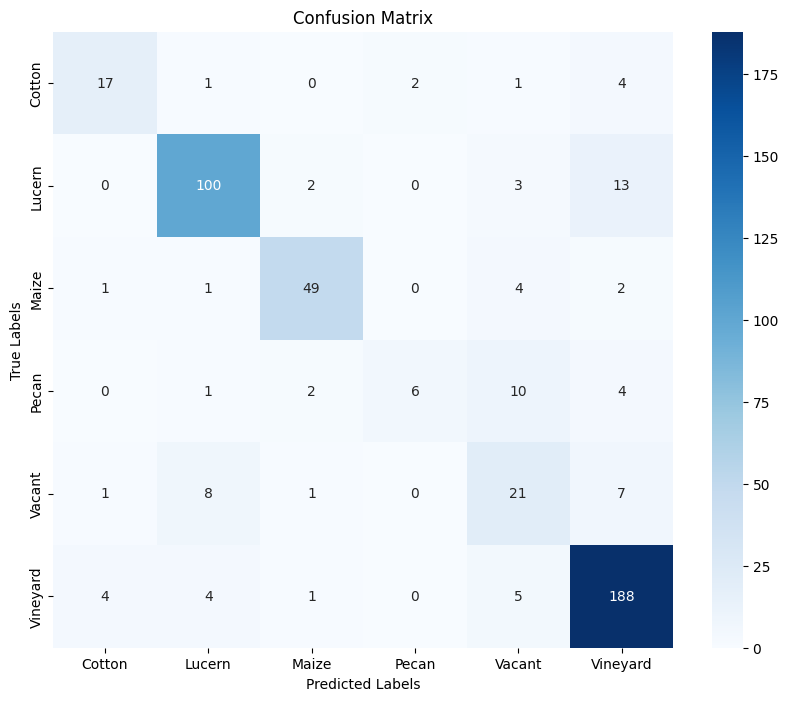

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#Prediction using Testes data

Once the model is generated, we will apply it to our test set:

In [ ]:
gdf_to_pred = gpd.read_file(path_test)

In [ ]:
gdf_to_pred

Field_Id       Area  Subregion  \
0            5   1.322590          3   
1            6   0.955864          3   
2           10  11.509800          3   
3           18   2.697520          3   
4           23   4.238030          3   
...        ...        ...        ...   
1069      3595   4.026750          6   
1070      3601   3.291510          7   
1071      3604   0.202729          3   
1072      3605   0.252428          3   
1073      3606   2.947200          3   

                                               geometry  
0     POLYGON ((614428.585 6794207.235, 614453.032 6...  
1     POLYGON ((614617.139 6794163.688, 614629.797 6...  
2     POLYGON ((614352.457 6794416.784, 614346.004 6...  
3     POLYGON ((587079.139 6809196.167, 587169.928 6...  
4     POLYGON ((587292.059 6809495.257, 587319.701 6...  
...                                                 ...  
1069  POLYGON ((544494.639 6857712.78, 544627.994 68...  
1070  POLYGON ((541538.301 6854638.691, 541373.855 6...  
1071  POLYGON ((614032.751 6794304.593, 614037.787 6...  
1072  POLYGON ((613963.294 6794488.531, 614007.44 67...  
1073  POLYGON ((614041.723 6794466.738, 614091.659 6...  

[1074 rows x 4 columns]

In [ ]:
columns_names = []
full_pred_id_list = []
full_pred_values_list = []
for date_path in os.listdir(path_images):
  for img_path in os.listdir(os.path.join(path_images, date_path)):
    img = rasterio.open(os.path.join(path_images, date_path, img_path))

    #print(img.shape)
    Mean_name_column = 'Mean_' + img_path.split('.')[0] + '_' + date_path

    columns_names.append(Mean_name_column)

    print(Mean_name_column)

    values_list = []
    id_list = []
    crop_id_list = []

    for i,row in poly_test.iterrows():
      coords = row['geometry']
      out_image, out_transform = mask(img, shapes=[coords], crop=True, nodata = -999)


      out_image = out_image.reshape(-1)
      out_image = out_image[out_image != -999]
      mean_img = out_image.mean()



      values_list.append(mean_img)
      id_list.append(row['Field_Id'])

    full_pred_values_list.append(values_list)
    full_pred_id_list.append(id_list)

Mean_B11_2017-01-01
Mean_B12_2017-01-01
Mean_B2_2017-01-01
Mean_B3_2017-01-01
Mean_B4_2017-01-01
Mean_B5_2017-01-01
Mean_B6_2017-01-01
Mean_B7_2017-01-01
Mean_B8_2017-01-01
Mean_B8A_2017-01-01
Mean_NDVI_2017-01-01
Mean_EVI_2017-01-01
Mean_NDWI_2017-01-01
Mean_SAVI_2017-01-01
Mean_B11_2017-03-12
Mean_B12_2017-03-12
Mean_B2_2017-03-12
Mean_B3_2017-03-12
Mean_B4_2017-03-12
Mean_B5_2017-03-12
Mean_B6_2017-03-12
Mean_B7_2017-03-12
Mean_B8_2017-03-12
Mean_B8A_2017-03-12
Mean_NDVI_2017-03-12
Mean_EVI_2017-03-12
Mean_NDWI_2017-03-12
Mean_SAVI_2017-03-12
Mean_B11_2017-05-31
Mean_B12_2017-05-31
Mean_B2_2017-05-31
Mean_B3_2017-05-31
Mean_B4_2017-05-31
Mean_B5_2017-05-31
Mean_B6_2017-05-31
Mean_B7_2017-05-31
Mean_B8_2017-05-31
Mean_B8A_2017-05-31
Mean_NDVI_2017-05-31
Mean_EVI_2017-05-31
Mean_NDWI_2017-05-31
Mean_SAVI_2017-05-31
Mean_B11_2017-07-10
Mean_B12_2017-07-10
Mean_B2_2017-07-10
Mean_B3_2017-07-10
Mean_B4_2017-07-10
Mean_B5_2017-07-10
Mean_B6_2017-07-10
Mean_B7_2017-07-10
Mean_B8_2017-07-10

In [ ]:
full_pred_values_array = np.array(full_pred_values_list).T
full_pred_id_array = np.array(full_pred_id_list)[0]

In [ ]:
full_pred_id_array

array([   5,    6,   10, ..., 3604, 3605, 3606])

In [ ]:
df_pred_full = pd.DataFrame(full_pred_values_array, columns=columns_names, index= full_pred_id_array)

In [ ]:
df_pred_full.reset_index(inplace=True, drop=True)

After extracting the information into a DataFrame, we will apply the trained model and obtain the predictions:

In [ ]:
df_pred_full

Mean_B11_2017-01-01  Mean_B12_2017-01-01  Mean_B2_2017-01-01  \
0                0.179676             0.087886            0.085017   
1                0.164851             0.076331            0.083845   
2                0.196050             0.089860            0.088379   
3                0.230801             0.123073            0.098984   
4                0.195758             0.095911            0.091392   
...                   ...                  ...                 ...   
1069             0.255704             0.142405            0.112586   
1070             0.137410             0.063189            0.089254   
1071             0.281100             0.187480            0.110547   
1072             0.217700             0.125526            0.096305   
1073             0.244026             0.157263            0.116254   

      Mean_B3_2017-01-01  Mean_B4_2017-01-01  Mean_B5_2017-01-01  \
0               0.083331            0.065139            0.103690   
1               0.080135            0.061308            0.096372   
2               0.093502            0.072727            0.119663   
3               0.105192            0.092055            0.137900   
4               0.092687            0.075398            0.113055   
...                  ...                 ...                 ...   
1069            0.122476            0.116126            0.154225   
1070            0.081639            0.060891            0.080862   
1071            0.118000            0.135993            0.174027   
1072            0.097300            0.103789            0.134163   
1073            0.121000            0.135112            0.157949   

      Mean_B6_2017-01-01  Mean_B7_2017-01-01  Mean_B8_2017-01-01  \
0               0.273820            0.362049            0.348022   
1               0.262211            0.347997            0.334631   
2               0.296585            0.383680            0.368375   
3               0.299153            0.377162            0.365053   
4               0.254319            0.320713            0.304772   
...                  ...                 ...                 ...   
1069            0.261213            0.306383            0.289409   
1070            0.238699            0.358522            0.339952   
1071            0.240607            0.280327            0.261613   
1072            0.217616            0.264479            0.253079   
1073            0.248038            0.301046            0.284554   

      Mean_B8A_2017-01-01  ...  Mean_B4_2017-07-10  Mean_B5_2017-07-10  \
0                0.397750  ...            0.107580            0.133267   
1                0.383804  ...            0.110825            0.135748   
2                0.426238  ...            0.114534            0.141695   
3                0.415371  ...            0.130983            0.155553   
4                0.353738  ...            0.130980            0.148268   
...                   ...  ...                 ...                 ...   
1069             0.338599  ...            0.143853            0.158827   
1070             0.388251  ...            0.172416            0.187289   
1071             0.307227  ...            0.157913            0.184900   
1072             0.298542  ...            0.082263            0.117753   
1073             0.330650  ...            0.114104            0.140211   

      Mean_B6_2017-07-10  Mean_B7_2017-07-10  Mean_B8_2017-07-10  \
0               0.193578            0.224794            0.221101   
1               0.190448            0.219073            0.221361   
2               0.200078            0.231137            0.233890   
3               0.189520            0.214115            0.216341   
4               0.172834            0.194803            0.198289   
...                  ...                 ...                 ...   
1069            0.187563            0.208756            0.206140   
1070            0.208960            0.231030            0.231598   
1071            0.237713      

In [ ]:
scaled_pred_data = scaler.transform(df_pred_full)
pca_pred_result = pca.transform(scaled_pred_data)

In [ ]:
data_pred = rf_classifier.predict(pca_pred_result)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [ ]:
data_pred

array(['Vineyard', 'Vineyard', 'Vineyard', ..., 'Vacant', 'Vineyard',
       'Vacant'], dtype=object)

In [ ]:
df_results_pred = pd.DataFrame(data_pred, columns=['crop_name'], index=full_pred_id_array)

In [ ]:
df_results_pred

crop_name
5     Vineyard
6     Vineyard
10    Vineyard
18    Vineyard
23    Vineyard
...        ...
3595  Vineyard
3601     Maize
3604    Vacant
3605  Vineyard
3606    Vacant

[1074 rows x 1 columns]

We merge the predictions with the polygon geodataframe:

In [ ]:
poly_test = pd.merge(poly_test, df_results_pred, left_on='Field_Id', right_index=True)

In [ ]:
poly_test

Field_Id       Area  Subregion  \
0            5   1.322590          3   
1            6   0.955864          3   
2           10  11.509800          3   
3           18   2.697520          3   
4           23   4.238030          3   
...        ...        ...        ...   
1069      3595   4.026750          6   
1070      3601   3.291510          7   
1071      3604   0.202729          3   
1072      3605   0.252428          3   
1073      3606   2.947200          3   

                                               geometry crop_name  
0     POLYGON ((614428.585 6794207.235, 614453.032 6...  Vineyard  
1     POLYGON ((614617.139 6794163.688, 614629.797 6...  Vineyard  
2     POLYGON ((614352.457 6794416.784, 614346.004 6...  Vineyard  
3     POLYGON ((587079.139 6809196.167, 587169.928 6...  Vineyard  
4     POLYGON ((587292.059 6809495.257, 587319.701 6...  Vineyard  
...                                                 ...       ...  
1069  POLYGON ((544494.639 6857712.78, 544627.994 68...  Vineyard  
1070  POLYGON ((541538.301 6854638.691, 541373.855 6...     Maize  
1071  POLYGON ((614032.751 6794304.593, 614037.787 6...    Vacant  
1072  POLYGON ((613963.294 6794488.531, 614007.44 67...  Vineyard  
1073  POLYGON ((614041.723 6794466.738, 614091.659 6...    Vacant  

[1074 rows x 5 columns]

In [ ]:
poly_test['crop_id'] = poly_test['crop_name'].

In [ ]:
inverse_dict_crop = {v: k for k, v in dict_crop.items()}
poly_test['crop_id'] = poly_test['crop_name'].map(inverse_dict_crop)

In [ ]:
poly_test

Field_Id       Area  Subregion  \
0            5   1.322590          3   
1            6   0.955864          3   
2           10  11.509800          3   
3           18   2.697520          3   
4           23   4.238030          3   
...        ...        ...        ...   
1069      3595   4.026750          6   
1070      3601   3.291510          7   
1071      3604   0.202729          3   
1072      3605   0.252428          3   
1073      3606   2.947200          3   

                                               geometry crop_name  crop_id  
0     POLYGON ((614428.585 6794207.235, 614453.032 6...  Vineyard        8  
1     POLYGON ((614617.139 6794163.688, 614629.797 6...  Vineyard        8  
2     POLYGON ((614352.457 6794416.784, 614346.004 6...  Vineyard        8  
3     POLYGON ((587079.139 6809196.167, 587169.928 6...  Vineyard        8  
4     POLYGON ((587292.059 6809495.257, 587319.701 6...  Vineyard        8  
...                                                 ...       ...      ...  
1069  POLYGON ((544494.639 6857712.78, 544627.994 68...  Vineyard        8  
1070  POLYGON ((541538.301 6854638.691, 541373.855 6...     Maize        5  
1071  POLYGON ((614032.751 6794304.593, 614037.787 6...    Vacant        7  
1072  POLYGON ((613963.294 6794488.531, 614007.44 67...  Vineyard        8  
1073  POLYGON ((614041.723 6794466.738, 614091.659 6...    Vacant        7  

[1074 rows x 6 columns]

In this way we can view our classified polygons:

In [ ]:
gdf_test_4326 = poly_test.to_crs(epsg=4326)

In [ ]:
gdf_test_4326['crop_id'] = pd.to_numeric(gdf_test_4326['crop_id'], errors='coerce')
gdf_test_4326 = gdf_test_4326.dropna(subset=['crop_id'])

In [ ]:
latitude = gdf_test_4326.dissolve().centroid.x
longitude = gdf_test_4326.dissolve().centroid.y

<ipython-input-128-1ec257f6ae03>:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude = gdf_test_4326.dissolve().centroid.x
<ipython-input-128-1ec257f6ae03>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  longitude = gdf_test_4326.dissolve().centroid.y


In [ ]:
m = folium.Map(location=[longitude, latitude], # center of the folium map # type of map
               min_zoom=10, max_zoom=16, # zoom range
               zoom_start=15) # initial zoom

# plot chorpleth over the base map
folium.Choropleth(gdf_test_4326,                                # geo data
                  data=gdf_test_4326,                           # data
                  key_on='feature.properties.Field_Id', # feature.properties.key
                  columns=['Field_Id', 'crop_id'],   # [key, value]
                  fill_color='RdYlGn',                     # cmap
                  line_weight=0.7,                       # line wight (of the border)
                  line_opacity=0.8,                      # line opacity (of the border)
                  legend_name='Cultivos').add_to(m)    # name on the legend color bar

# add layer controls
folium.LayerControl().add_to(m)

m

/usr/local/lib/python3.10/dist-packages/folium/utilities.py:94: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(coord)
/usr/local/lib/python3.10/dist-packages/folium/utilities.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  if math.isnan(float(coord)):
/usr/local/lib/python3.10/dist-packages/folium/utilities.py:102: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return [float(x) for x in coords]
